In [27]:
import os
# Ensure LaTeX binary is in PATH
os.environ["PATH"] = "/Library/TeX/texbin:" + os.environ["PATH"]
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def load_results(dataset_type):
    df_list = []
    time_res_list = [0.1, 0.2, 0.25, 0.5, 1.0] 
    count_bins_list = [100_000, 200_000, 300_000, 500_000, 1_000_000]

    # Load time-bin results
    for time in time_res_list:
        path = f'./results/vpr_results_{dataset_type}_fixed_timebins_{time}.csv'
        try:
            df_temp = pd.read_csv(path)
            df_temp['time_res'] = f'time_{time}'
            if not df_temp.empty:
                df_list.append(df_temp)
        except FileNotFoundError:
            print(f"File {path} not found.")

    # Load count-bin results
    for count in count_bins_list:
        path = f'./results/vpr_results_{dataset_type}_fixed_countbins_{count}.csv'
        try:
            df_temp = pd.read_csv(path)
            df_temp['time_res'] = df_temp['time_res'].fillna(f'count_{count}')
            if not df_temp.empty:
                df_list.append(df_temp)
        except FileNotFoundError:
            print(f"File {path} not found.")
            continue

    # Concatenate all
    if not df_list:
        return pd.DataFrame()  # Return empty if nothing was loaded

    df = pd.concat(df_list, ignore_index=True)

    # Drop duplicates excluding 'runtime'
    cols_ex_runtime = [col for col in df.columns if col != 'runtime']
    df = df.drop_duplicates(subset=cols_ex_runtime)

    return df

# Matplotlib settings for LaTeX-like appearance
import matplotlib.pyplot as plt
plt.rcParams.update({
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'legend.title_fontsize': 10,
    'text.usetex': True
})
sns.set_theme(style="whitegrid", font_scale=1.6)
rename_map = {
    'R0_FA0': 'FA0',
    'R0_FN0': 'FN0',
    'R0_FS0': 'FS0',
    'R0_RA0': 'RA0',
    'R0_RN0': 'RN0',
    'R0_RS0': 'RS0',
}



<ipython-input-2-676661d0fa6e>:181: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1.02])


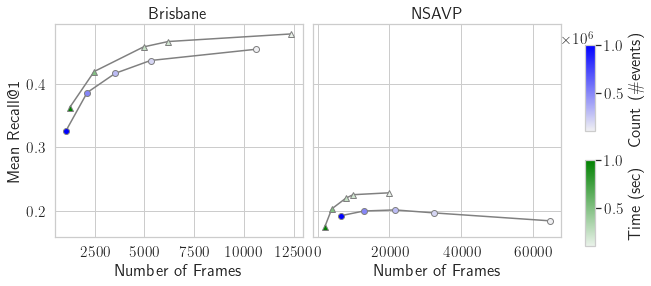

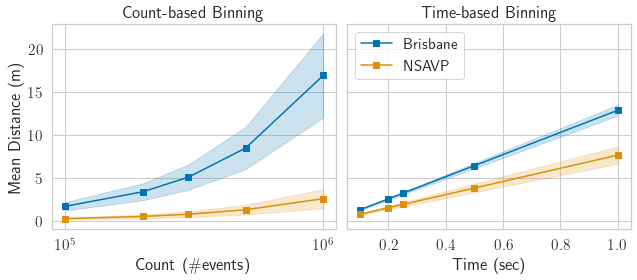

In [ ]:
# Comaparison of count and time bins - plot abd print displacement table
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
from typing import Union, List


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import seaborn as sns
import pandas as pd
sns.set_theme(style="whitegrid", font_scale=1.4)

def plot_performance_vs_compute_side_by_side(df1, df2, group_feature='time_res', mode='frame', ds1='Brisbane', ds2='NSAVP'):
    assert mode in ['patch', 'frame'], "mode must be 'patch' or 'frame'"

    def prepare_data(df):
        grouped = df.groupby([group_feature, 'patch_or_frame']).agg({
            'recall_at_1': ['mean', 'count'],
            'num_ref_frames': 'mean',
            'num_qry_frames': 'mean'
        }).reset_index()

        # Flatten MultiIndex column names
        grouped.columns = ['group', 'patch_or_frame', 'recall_at_1', 'count', 'num_ref_frames', 'num_qry_frames']

        grouped['compute_cost'] = grouped['num_ref_frames'] + grouped['num_qry_frames']

        def categorize(x):
            if str(x).startswith('count_'):
                return 'count'
            elif str(x).startswith('time_'):
                return 'time'
            else:
                return 'other'

        grouped['category'] = grouped['group'].apply(categorize)
        grouped = grouped[(grouped['patch_or_frame'] == mode) & grouped['category'].isin(['count', 'time'])]
        grouped['bin_value'] = grouped['group'].str.extract(r'_(\d+\.?\d*)')[0].astype(float)
        grouped = grouped.sort_values(by=['category', 'compute_cost'])
        return grouped

    grouped1 = prepare_data(df1)
    grouped2 = prepare_data(df2)

    # Normalize for color mapping
    norm_count = mcolors.Normalize(vmin=grouped1[grouped1['category'] == 'count']['bin_value'].min(),
                                   vmax=grouped1[grouped1['category'] == 'count']['bin_value'].max())
    norm_time = mcolors.Normalize(vmin=grouped1[grouped1['category'] == 'time']['bin_value'].min(),
                                  vmax=grouped1[grouped1['category'] == 'time']['bin_value'].max())
    cmap_count = sns.light_palette("blue", as_cmap=True)
    cmap_time = sns.light_palette("green", as_cmap=True)
    marker_map = {'count': 'o', 'time': '^'}

    fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

    for ax, grouped, title in zip(axs, [grouped1, grouped2], [ds1, ds2]):
        for category in ['count', 'time']:
            cat_data = grouped[grouped['category'] == category]
            norm = norm_count if category == 'count' else norm_time
            cmap = cmap_count if category == 'count' else cmap_time
            marker = marker_map[category]

            # Plot lines and points
            ax.plot(cat_data['compute_cost'], cat_data['recall_at_1'], color='gray', linestyle='-', zorder=1)
            for _, row in cat_data.iterrows():
                color = cmap(norm(row['bin_value']))
                ax.plot(row['compute_cost'], row['recall_at_1'],
                        marker=marker, color='gray',
                        markerfacecolor=color, zorder=2)

        ax.set_title(f"{title}")
        ax.set_xlabel("Number of Frames")

    axs[0].set_ylabel("Mean Recall@1")

    # Colorbars
    cbar_ax1 = fig.add_axes([0.92, 0.55, 0.015, 0.3])
    cbar_ax2 = fig.add_axes([0.92, 0.15, 0.015, 0.3])
    sm_count = ScalarMappable(norm=norm_count, cmap=cmap_count)
    sm_time = ScalarMappable(norm=norm_time, cmap=cmap_time)
    sm_count.set_array([])
    sm_time.set_array([])
    # Use \# instead of # for LaTeX compatibility in colorbar labels
    fig.colorbar(sm_count, cax=cbar_ax1).set_label(r"Count (\#events)")
    fig.colorbar(sm_time, cax=cbar_ax2).set_label(r"Time (sec)")

    plt.tight_layout(rect=[0, 0, 0.9, 1.02])
    plt.savefig('./plots/0_performance_across_bintypes_and_binsize.pdf', bbox_inches='tight')



def plot_displacement_with_variance(df):
    fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)

    # Color and marker settings
    datasets = df['dataset'].unique()
    palette = sns.color_palette("colorblind", n_colors=len(datasets))
    color_map = {ds: palette[i] for i, ds in enumerate(datasets)}
    marker_map = {'count': 's', 'time': 's'}

    for i, btype in enumerate(['count', 'time']):
        ax = axes[i]
        subset = df[df['binning_type'] == btype]

        for dataset in datasets:
            dset_data = subset[subset['dataset'] == dataset].sort_values('binning_value')
            x = dset_data['binning_value'].values
            y = dset_data['mean'].values
            yerr = dset_data['std'].values

            ax.plot(x, y,
                    marker=marker_map[btype],
                    linestyle='-',
                    color=color_map[dataset],
                    label=dataset)
            ax.fill_between(x, y - yerr, y + yerr,
                            color=color_map[dataset],
                            alpha=0.2)

        ax.set_title("Count-based Binning" if btype == 'count' else "Time-based Binning")
        ax.set_xlabel(r"Count (\#events)" if btype == 'count' else r"Time (sec)")
        if btype == 'count':
            ax.set_xscale('log')
        ax.grid(True)
        if i == 1:
            ax.legend(loc='upper left')

    axes[0].set_ylabel("Mean Distance (m)")
    plt.tight_layout()
    plt.savefig('./plots/0_displacement_across_bintypes_and_binsize.pdf', bbox_inches='tight')



def print_compact_displacement_table(csv_path: str):
    """
    Prints a LaTeX table with:
    - Two blocks: one for count bins, one for time bins
    - Custom headers and horizontal lines
    - Formatted as \resizebox{\columnwidth}{!}{...}
    """
    df = pd.read_csv(csv_path)

    # Filter out count_1e6 if present
    df = df[~((df['binning_type'] == 'time') & (df['binning_value'] == 0.15))]

    # Aggregate mean ± std
    agg = df.groupby(['binning_type', 'dataset', 'binning_value'])['mean_displacement'].agg(['mean', 'std']).reset_index()
    agg['formatted'] = agg.apply(lambda r: f"{r['mean']:.2f} ± {r['std']:.2f}", axis=1)

    plot_displacement_with_variance(agg)




df1 = load_results('Brisbane')
df1 = df1[(df1['vpr_method'] != 'anyloc-urban') & (df1['reconstruction_name'] != 'RGB_camera') & (df1['seq_len'] == 1) & (df1['binning_strategy'] == 'fixed') ]

df2 = load_results('NSAVP')
df2 = df2[(df2['vpr_method'] != 'anyloc-urban') & (df2['reconstruction_name'] != 'RGB_camera')& (df2['seq_len'] == 1) & (df2['binning_strategy'] == 'fixed') ]

displacement_csv = './hpc/displacement_per_traverse1.csv'

plot_performance_vs_compute_side_by_side(df1, df2, group_feature='time_res', mode='frame')
print_compact_displacement_table(displacement_csv)


Mean Recall@1 for e2vid: Day=0.6326, Night=0.0855
Mean Recall@1 for eventCount: Day=0.5218, Night=0.1180
Mean Recall@1 for eventCount_noPolarity: Day=0.4536, Night=0.1102
Mean Recall@1 for timeSurface: Day=0.5566, Night=0.1102
Mean Recall@1 for mixvpr: Day=0.6534, Night=0.1119, Total=0.3827
Mean Recall@1 for megaloc: Day=0.6696, Night=0.1689, Total=0.4192
Mean Recall@1 for cosplace: Day=0.4166, Night=0.0694, Total=0.2430
Mean Recall@1 for netvlad: Day=0.4250, Night=0.0737, Total=0.2493
✅ Saved circular line plot to ./plots/0_performance_across_vpr_method.pdf
✅ Saved circular line plot to ./plots/0_performance_across_reconstruction_name.pdf


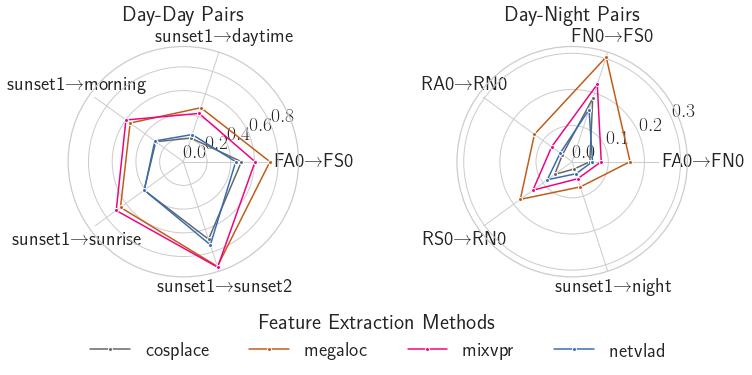

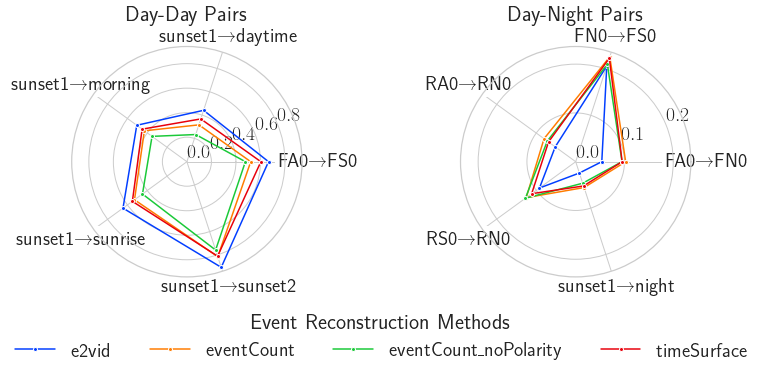

In [2]:
# Radar plot frame based results with no seq matching for VPR methods and reconstruction methods
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import matplotlib.patches as mpatches
# Improve plot appearance for LaTeX publications

def radar_plot_vpr_publication(df, group_feature='vpr_method', cPallete='muted'):
    """Publication-quality radar plot for VPR methods with separate rows for each sequence length"""
    
    df = df.copy()
    
    df['ref_seq'] = df['ref_seq'].map(rename_map).fillna(df['ref_seq'])
    df['qry_seq'] = df['qry_seq'].map(rename_map).fillna(df['qry_seq'])
    df['pair'] = df['ref_seq'] + " vs. " + df['qry_seq']
    
    # Get unique sequence lengths and sort them
    seq_lengths = sorted(df['seq_len'].unique())
    n_seq_lengths = len(seq_lengths)
    
    # Create subplots: rows for seq_len, columns for day/night
    fig, axs = plt.subplots(n_seq_lengths, 2, figsize=(7, 3* n_seq_lengths), 
                           subplot_kw=dict(polar=True))
    
    # Handle case where there's only one sequence length
    if n_seq_lengths == 1:
        axs = axs.reshape(1, -1)
    
    fig.subplots_adjust(bottom=0.1, top=0.85, left=0.05, right=0.95, hspace=0.3)
    
    # Use seaborn color palette for VPR methods
    vpr_colors = sns.color_palette(cPallete, 5)
    all_handles = []
    label_names = []
    
    for row_idx, seq_len in enumerate(seq_lengths):
        # Filter data for current sequence length
        df_seq = df[df['seq_len'] == seq_len]
        # Filter for night and day sequences
        df_night = df_seq[df_seq['pair'].str.contains("night|N0", case=False, na=False)]
        df_day = df_seq[~df_seq['pair'].str.contains("night|N0", case=False, na=False)]
        
        for col_idx, (subset, title_suffix) in enumerate(zip([df_day, df_night], 
                                                            ['Day Conditions', 'Night Conditions'])):
            ax = axs[row_idx, col_idx]
            grouped = subset.groupby([group_feature, 'pair'])['auc'].mean().unstack(fill_value=0)
            if grouped.empty:
                ax.text(0.5, 0.5, 'No Data Available', transform=ax.transAxes, 
                       ha='center', va='center', style='italic')
                ax.set_title(title)
                ax.grid(False)
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            
            # Sort by mean performance
            # print(grouped.count())
            mean_scores = grouped.mean(axis=1)
            grouped = grouped.loc[mean_scores.sort_values(ascending=False).index]
            color_map = dict(zip(grouped.index, vpr_colors[:len(grouped)]))
            
            pair_labels = grouped.columns.tolist()
            angles = np.linspace(0, 2 * np.pi, len(pair_labels), endpoint=False).tolist()
            angles += angles[:1]
            
            for method in grouped.index:
                values = grouped.loc[method].tolist() + [grouped.loc[method].tolist()[0]]
                color = color_map[method]
                
                line, = ax.plot(angles, values, label=method, color=color, marker='.',
                               markerfacecolor=color, markeredgecolor='white')
                ax.fill(angles, values, alpha=0.05, color=color)
                
            # Set axis ticks
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(pair_labels, fontsize=9)
            
            # Rotate tick labels outward
            for label, angle in zip(ax.get_xticklabels(), angles):
                label.set_rotation(np.degrees(angle))
                label.set_horizontalalignment('center')

            ax.set_title({title_suffix}, va='bottom', fontsize=12)
            # title = f'{title_suffix}'
            # ax.set_title(title)
    
    # Single legend below all plots
    if group_feature == 'reconstruction_name':
        legend_title = 'Event Reconstruction Methods'
    else:   
        legend_title = 'Feature Extraction Methods'
    fig.legend(all_handles, label_names, loc='lower center', 
              bbox_to_anchor=(0.5, -0.15), ncol=4, 
              frameon=False, title=legend_title)
    
    type_name = 'Event Reconstruction Method' if group_feature == 'reconstruction_name' else 'VPR Method'
    # plt.suptitle(f"Recall@1 {type_name}\nunder Varied Illumination Conditions and Sequence Lengths", y=1.02)
    
    # Save high-quality outputs
    save_path = f'./plots/0_performance_across_{group_feature}_by_seqlen.pdf'
    plt.savefig(save_path, format='pdf', bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    

def circular_line_plot_vpr_publication(df, group_feature='vpr_method', cPallete='tab10'):
    """
    Circular line plot version of radar plot: cleaner for publication.
    Two subplots (day/night) for each sequence length, with polar lines per method.
    """
    df = df.copy()
    df['ref_seq'] = df['ref_seq'].map(rename_map).fillna(df['ref_seq'])
    df['qry_seq'] = df['qry_seq'].map(rename_map).fillna(df['qry_seq'])
    df['ref_seq'] = df['ref_seq'].str.replace(r'^R0_', '', regex=True)
    df['qry_seq'] = df['qry_seq'].str.replace(r'^R0_', '', regex=True)
    df['pair'] = df['ref_seq'] + "→" + df['qry_seq']

    

    seq_lengths = sorted(df['seq_len'].unique())
    n_seq_lengths = len(seq_lengths)

    fig, axs = plt.subplots(n_seq_lengths, 2, figsize=(11, 4 * n_seq_lengths),
                            subplot_kw=dict(polar=True))
    if n_seq_lengths == 1:
        axs = axs.reshape(1, -1)

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.05, right=0.95, hspace=0.4)

    method_colors = sns.color_palette(cPallete, 8)

    all_handles = []
    label_names = []

    for row_idx, seq_len in enumerate(seq_lengths):
        df_seq = df[df['seq_len'] == seq_len]
        df_night = df_seq[df_seq['pair'].str.contains("night|N0", case=False, na=False)]
        df_day = df_seq[~df_seq['pair'].str.contains("night|N0", case=False, na=False)]

        for col_idx, (subset, title_suffix) in enumerate(zip([df_day, df_night],
                                                             ['Day-Day Pairs', 'Day-Night Pairs'])):
            ax = axs[row_idx, col_idx]
            grouped = subset.groupby([group_feature, 'pair'])['recall_at_1'].mean().unstack()

            # Angles for circular layout
            pair_labels = grouped.columns.tolist()
            angles = np.linspace(0, 2 * np.pi, len(pair_labels), endpoint=False).tolist()
            angles += angles[:1]  # loop back

            color_map = dict(zip(grouped.index, method_colors))

            for i, method in enumerate(grouped.index):
                vals = grouped.loc[method].values
                values = np.append(vals, vals[0])

                color = color_map[method]
                line, = ax.plot(angles, values, label=method,
                                color=color, marker='o', markersize=4,
                                markerfacecolor=color, markeredgecolor='white')
                # ax.fill(angles, values, alpha=0.01, color=color)

                if row_idx == 0 and col_idx == 0:
                    all_handles.append(line)
                    label_names.append(method)

            # Axis settings
            ax.set_xticks(angles[:-1])
            # Set tick labels and bring them to front
            
            for label, angle in zip(ax.get_xticklabels(), angles):
                label.set_rotation(np.degrees(angle))
                label.set_horizontalalignment('center')
                label.set_bbox(dict(facecolor='white', alpha=1, edgecolor='none'))
            ax.set_xticklabels(pair_labels)

            max_y = max([max(grouped.loc[method]) for method in grouped.index])
            if max_y < 0.5:
                ax.set_yticks(np.arange(0, max_y, 0.1))
            else:
                ax.set_yticks(np.arange(0, max_y, 0.2))
            ax.set_title(f"{title_suffix}", fontweight='bold')


    for label in ax.get_xticklabels():
        label.set_zorder(30)
    # Legend
    legend_title = 'Event Reconstruction Methods' if group_feature == 'reconstruction_name' else 'Feature Extraction Methods'
    fig.legend(all_handles, label_names, loc='lower center',
               bbox_to_anchor=(0.5, -0.25), ncol=4, frameon=False, title=legend_title, title_fontproperties={'weight': 'bold'})

    # Save
    save_path = f'./plots/0_performance_across_{group_feature}.pdf'
    plt.savefig(save_path, format='pdf', bbox_inches='tight', facecolor='white')
    print(f"✅ Saved circular line plot to {save_path}")
    # plt.show()

# Example usage (uncomment when you have your data):
df = pd.concat([load_results('Brisbane'), load_results('NSAVP')], ignore_index=True)
df = df[df['vpr_method'] != 'anyloc-urban']  
# df = df[df['vpr_method'] == 'mixvpr']  # Use 'mixvpr' for VPR-only plot
df = df[(df['seq_len'] == 1)]
df = df[df['bin_type'] == 'timebin']
df = df[df['patch_or_frame']== 'frame']
df = df[df['reconstruction_name'] != 'RGB_camera']

for recon_name in ['e2vid', 'eventCount', 'eventCount_noPolarity', 'timeSurface']:
    recon_df = df[df['reconstruction_name'] == recon_name]
    # Create 'pair' column as in your plotting code
    recon_df = recon_df.copy()
    recon_df['ref_seq'] = recon_df['ref_seq'].map(rename_map).fillna(recon_df['ref_seq'])
    recon_df['qry_seq'] = recon_df['qry_seq'].map(rename_map).fillna(recon_df['qry_seq'])
    recon_df['pair'] = recon_df['ref_seq'] + " vs. " + recon_df['qry_seq']

    df_night = recon_df[recon_df['pair'].str.contains("night|N0", case=False, na=False)]
    df_day = recon_df[~recon_df['pair'].str.contains("night|N0", case=False, na=False)]

    mean_recall_day = df_day['recall_at_1'].mean()
    mean_recall_night = df_night['recall_at_1'].mean()
    print(f"Mean Recall@1 for {recon_name}: Day={mean_recall_day:.4f}, Night={mean_recall_night:.4f}")

for vpr in ['mixvpr', 'megaloc', 'cosplace', 'netvlad']:
    recon_df = df[df['vpr_method'] == vpr]
    # Create 'pair' column as in your plotting code
    recon_df = recon_df.copy()
    recon_df['ref_seq'] = recon_df['ref_seq'].map(rename_map).fillna(recon_df['ref_seq'])
    recon_df['qry_seq'] = recon_df['qry_seq'].map(rename_map).fillna(recon_df['qry_seq'])
    recon_df['pair'] = recon_df['ref_seq'] + " vs. " + recon_df['qry_seq']

    df_night = recon_df[recon_df['pair'].str.contains("night|N0", case=False, na=False)]
    df_day = recon_df[~recon_df['pair'].str.contains("night|N0", case=False, na=False)]

    mean_recall_day = df_day['recall_at_1'].mean()
    mean_recall_night = df_night['recall_at_1'].mean()
    print(f"Mean Recall@1 for {vpr}: Day={mean_recall_day:.4f}, Night={mean_recall_night:.4f}, Total={(mean_recall_day + mean_recall_night)/2:.4f}")

# For VPR-only plot:
circular_line_plot_vpr_publication(df, group_feature='vpr_method',  cPallete='Accent_r')
circular_line_plot_vpr_publication(df, group_feature='reconstruction_name', cPallete='bright')

In [ ]:
#Sequence match table and scatter plot
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_ind

def plot_recall_scatter(df):
    """Option 4: Scatter Plot - Shows relationship between sequence length and recall"""
    
    # Same preprocessing
    df['ref_seq_renamed'] = df['ref_seq'].map(rename_map).fillna(df['ref_seq'])
    df['qry_seq_renamed'] = df['qry_seq'].map(rename_map).fillna(df['qry_seq'])
    df = df[df['patch_or_frame'] == 'frame']
    
    grouped = (
        df.groupby(['time_res', 'seq_len'])
        .agg(recall_at_1_mean=('recall_at_1', 'mean'))
        .reset_index()
    )
    grouped['pair_label'] = grouped['time_res'].str.split('_').str[-1] + ' sec timebin'  # grouped['pair_label'] = grouped['ref_seq_renamed'] + ' → ' + grouped['qry_seq_renamed']
    grouped['recall_percent'] = grouped['recall_at_1_mean'] * 100
    
    plt.figure(figsize=(5, 3))
    
    pairs = grouped['pair_label'].unique()
    colors = plt.cm.tab10(np.linspace(0, 1, len(pairs)))
    
    for i, pair in enumerate(pairs):
        data = grouped[grouped['pair_label'] == pair]
        plt.plot(data['seq_len'], data['recall_percent'], 
                 label=pair, color=colors[i], marker='o', markersize=4, 
                 linewidth=1.5, alpha=0.7)
        
    
    plt.xlabel('Sequence Length')
    plt.ylabel('Recall@1 (%)')
    plt.title('Recall@1 vs Sequence Length by Sequence Pair')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig("./plots/recall_scatter.pdf", format='pdf', bbox_inches='tight')
    plt.show()

def generate_seqmatch_improvement_table_with_timeres(df):
    import pandas as pd
    

    # Rename sequences and create pair labels
    df['ref_seq_renamed'] = df['ref_seq'].map(rename_map).fillna(df['ref_seq'])
    df['qry_seq_renamed'] = df['qry_seq'].map(rename_map).fillna(df['qry_seq'])
    df['pair_label'] = df['ref_seq_renamed'] + ' → ' + df['qry_seq_renamed']

    # Filter to frame-based and timebin-type only
    df = df[(df['patch_or_frame'] == 'frame') & (df['bin_type'] == 'timebin')]

    # Group by pair, time resolution, and sequence length
    grouped = (
        df.groupby(['pair_label', 'time_res', 'seq_len'])
        .agg(recall=('recall_at_1', 'mean'))
        .reset_index()
    )

    # Pivot to wide format: rows=(pair_label, time_res), columns=seq_len
    pivot = grouped.pivot(index=['pair_label', 'time_res'], columns='seq_len', values='recall') * 100

    # Ensure baseline exists
    if 1 not in pivot.columns:
        raise ValueError("Sequence length 1 is required for baseline comparison.")

    # Subtract baseline (seq_len = 1)
    improvements = pivot.subtract(pivot[1], axis=0).drop(columns=[1])

    # Mean improvement across sequence pairs, grouped by time_res
    mean_improvements = improvements.groupby(level='time_res').mean().round(2)

    # Generate LaTeX table
    latex = "\\begin{table}[ht]\n\\centering\n"
    latex += "\\begin{tabular}{l" + "c" * len(mean_improvements.columns) + "}\n"
    latex += "\\toprule\n"
    latex += "Time Resolution & " + " & ".join([f"SeqLen {int(c)}" for c in mean_improvements.columns]) + " \\\\\n"
    latex += "\\midrule\n"

    for time_res in mean_improvements.index:
        row_vals = " & ".join([f"{mean:.2f}" for mean in mean_improvements.loc[time_res]])
        latex += f"{time_res} & {row_vals} \\\\\n"

    latex += "\\bottomrule\n"
    latex += "\\end{tabular}\n"
    latex += "\\caption{Mean Recall@1 improvement over SeqLen=1 for each time resolution.}\n"
    latex += "\\label{tab:seqmatch_improvement_timeres}\n"
    latex += "\\end{table}"

    print(latex)


# Usage example:
csv_path = './results/seqMatch_vs_modified_results_fixed_timebins.csv'
df = pd.read_csv(csv_path)
columns_to_check = [
    'ref_seq', 'qry_seq', 'reconstruction_name', 'vpr_method', 'seq_len',
    'bin_type', 'binning_strategy', 'events_per_bin', 'time_res',
    'positive_dist_thresh', 'patch_or_frame', 'seq_match_type']
df = df.drop_duplicates(subset=columns_to_check)
df = df[(df['seq_len'].isin([10, 20, 30]))]
df = df[(df['time_res'].isin([1.0, 0.5, 0.25, 0.2, 0.1]))]
df = df[df['patch_or_frame'] == 'frame']
# df = df[df['ref_seq'] == 'sunset1']

# Group and aggregate
grouped = df.groupby(['seq_len', 'seq_match_type'])['recall_at_1'].agg(['mean', 'std']).reset_index()
# Count number of samples per group
counts = df.groupby(['seq_len', 'seq_match_type']).size().reset_index(name='count')
# Print or display the counts
print(counts)

# Pivot for plotting
pivot = grouped.pivot(index='seq_len', columns='seq_match_type', values='mean')
pivot_std = grouped.pivot(index='seq_len', columns='seq_match_type', values='std')





# Print LaTeX tabular with p-value column
grouped['formatted'] = grouped.apply(lambda x: f"{x['mean']:.4f} ± {x['std']:.4f}", axis=1)

# Calculate p-values for each seq_len between 'seqslam' and 'modified'
pvalues = []
for seq_len in grouped['seq_len'].unique():
    vals_seqslam = df[df['seq_len'] == seq_len]
    vals_seqslam = vals_seqslam[vals_seqslam['seq_match_type'] == 'seqslam']['recall_at_1']
    vals_modified = df[df['seq_len'] == seq_len]
    vals_modified = vals_modified[vals_modified['seq_match_type'] == 'modified']['recall_at_1']
    if len(vals_seqslam) > 1 and len(vals_modified) > 1:
        stat, pval = ttest_ind(vals_seqslam, vals_modified, equal_var=False, nan_policy='omit')
    else:
        pval = float('nan')
    pvalues.append((seq_len, pval))

pvalue_dict = dict(pvalues)

latex_table = grouped.pivot(index='seq_len', columns='seq_match_type', values='formatted')[['seqslam', 'modified']]
latex_table['p-value'] = latex_table.index.map(
    lambda x: f"{pvalue_dict.get(x):.4f}" if not pd.isna(pvalue_dict.get(x)) else "--"
)

print("\\begin{tabular}{lcc|c}")
print("Seq Len & seqslam & modified & p-value \\\\ \\hline")
for seq_len in latex_table.index:
    row = [latex_table.loc[seq_len, col] if pd.notna(latex_table.loc[seq_len, col]) else "--" for col in ['seqslam', 'modified']]
    # Bold the highest value per row
    float_vals = []
    for val in row:
        try:
            float_val = float(val.split('±')[0].strip())
        except Exception:
            float_val = float('-inf')
        float_vals.append(float_val)
    max_idx = int(np.argmax(float_vals))
    row_bolded = []
    for i, val in enumerate(row):
        if i == max_idx:
            row_bolded.append(f"\\textbf{{{val}}}")
        else:
            row_bolded.append(val)
    pval_str = latex_table.loc[seq_len, 'p-value']
    print(f"{seq_len} & " + " & ".join(row_bolded) + f" & {pval_str} \\\\")
print("\\end{tabular}")


   seq_len seq_match_type  count
0       10       modified    800
1       10        seqslam    800
2       20       modified    800
3       20        seqslam    800
4       30       modified    800
5       30        seqslam    800
\begin{tabular}{lcc|c}
Seq Len & seqslam & modified & p-value \\ \hline
10 & \textbf{0.3473 ± 0.3124} & 0.3410 ± 0.3151 & 0.6874 \\
20 & 0.4301 ± 0.3264 & \textbf{0.4613 ± 0.3257} & 0.0554 \\
30 & 0.4593 ± 0.3135 & \textbf{0.4996 ± 0.3085} & 0.0096 \\
\end{tabular}


/tmp/ipykernel_2967624/2786701779.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ensmeble_all['ref_name'] = ensmeble_all['ref_name'].str.replace(r'^R0_', '', regex=True)
/tmp/ipykernel_2967624/2786701779.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ensmeble_all['qry_name'] = ensmeble_all['qry_name'].str.replace(r'^R0_', '', regex=True)
/tmp/ipykernel_2967624/2786701779.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Max-collapsed Recall@1 per ensemble type and count:
                       ensemble_type      mean       max  count
0             Best Individual Member  0.470758  0.922261     10
1                      Baseline [11]  0.529544  0.925664     10
2  Ensemble of Event Reconstructions  0.546110  0.924028     10
3     Ensemble of Feature Extractors  0.566437  0.927498     10
4                  Combined Ensemble  0.643737  0.927434     10


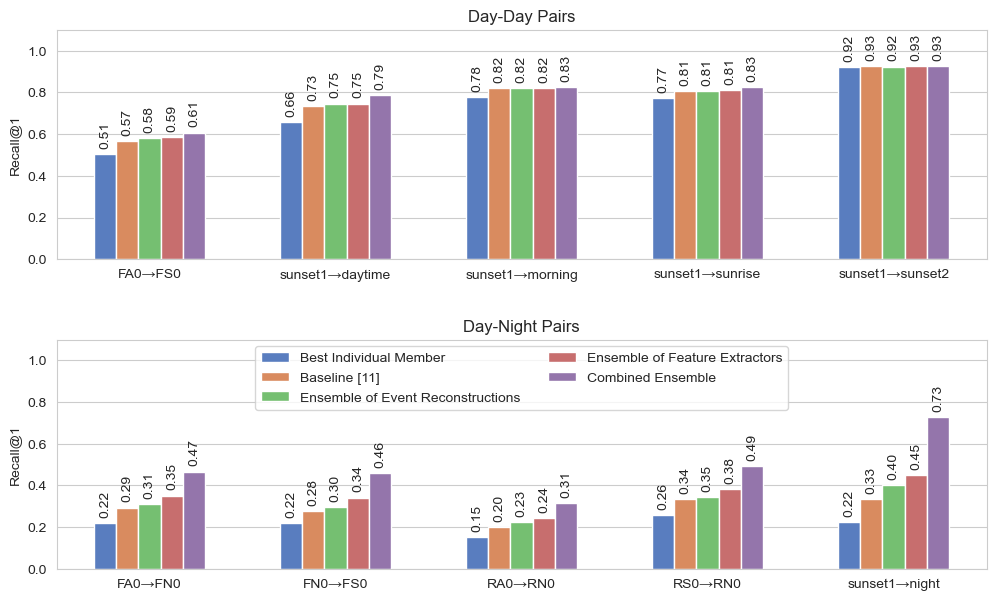

In [12]:
# ensemble additional results with individual member recall values
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
import matplotlib.ticker as mtick

# Classify time of day
def classify_day_night(name):
    name = name.lower()
    return 'night' if ('night' in name or 'n0' in name) else 'day'

# Load ensemble results with individual member recall values
ensemble_df = pd.read_csv('./hpc/ablate_ensemble_combination_additionalResults.csv')
ensemble_df.columns = ensemble_df.columns.str.strip()

# results from combining all ensemble members
ensmeble_all=  ensemble_df[ensemble_df['ensemble_over'] == 'all']
ensmeble_all['ref_name'] = ensmeble_all['ref_name'].str.replace(r'^R0_', '', regex=True)
ensmeble_all['qry_name'] = ensmeble_all['qry_name'].str.replace(r'^R0_', '', regex=True)
ensmeble_all['ref_qry_pair'] = ensmeble_all['ref_name'] + '→' + ensmeble_all['qry_name']
ensmeble_all = ensmeble_all[ensmeble_all['seqLen'].isin([10, 20, 30])]
ensmeble_all.rename(columns={'seqLen': 'seq_len'}, inplace=True)
ensmeble_all['time_of_day'] = (ensmeble_all['ref_name'] + '→' + ensmeble_all['qry_name']).apply(classify_day_night)
ensmeble_all['ensemble_type'] = 'Combined Ensemble'

# Parse and extract best individual recall
ensemble_df['recall@1_individual'] = ensemble_df['recall@1_individual'].apply(ast.literal_eval)
ensemble_df['best_member_recall'] = ensemble_df['recall@1_individual'].apply(np.mean)

# Create ref_qry_pair and keep only required sequence lengths
ensemble_df['ref_name'] = ensemble_df['ref_name'].str.replace(r'^R0_', '', regex=True)
ensemble_df['qry_name'] = ensemble_df['qry_name'].str.replace(r'^R0_', '', regex=True)
ensemble_df['ref_qry_pair'] = ensemble_df['ref_name'] + '→' + ensemble_df['qry_name']
ensemble_df = ensemble_df[ensemble_df['seqLen'].isin([10, 20, 30])]
ensemble_df.rename(columns={'seqLen': 'seq_len'}, inplace=True)

# Simplify ensemble types
rename_map = {
    'time': 'Baseline [11]',
    'recon': 'Ensemble of Event Reconstructions',
    'vpr': 'Ensemble of Feature Extractors',
    'all': 'Combined Ensemble'
}
ensemble_df['ensemble_type'] = ensemble_df['ensemble_over'].map(rename_map)
ensemble_df['ensemble_type'] = ensemble_df['ensemble_type'].fillna('Other')

# Classify day/night
ensemble_df['time_of_day'] = (ensemble_df['ref_name'] + '→' + ensemble_df['qry_name']).apply(classify_day_night)

# Build per-row values for plotting
# 1) Ensemble results: use the provided recall@1_mean column as the per-config value, then later take max across seq_len
ens_vals = ensemble_df[['ref_qry_pair', 'seq_len', 'ensemble_type', 'time_of_day', 'recall@1_mean']].copy()
ens_vals.rename(columns={'recall@1_mean': 'Recall@1'}, inplace=True)

# 2) Best individual member per config, then later take max across seq_len
ind_best = ensemble_df[['ref_qry_pair', 'seq_len', 'time_of_day', 'best_member_recall']].copy()
ind_best.rename(columns={'best_member_recall': 'Recall@1'}, inplace=True)
ind_best['ensemble_type'] = 'Best Individual Member'

# Combine
plot_df = pd.concat([ens_vals, ind_best], ignore_index=True)

# Take MAX across seq_len for each (time_of_day, ref_qry_pair, ensemble_type)
plot_df = (
    plot_df.groupby(['time_of_day', 'ref_qry_pair', 'ensemble_type'], as_index=False)['Recall@1']
    .median()
)

# Order categories
ensemble_order = [
    'Best Individual Member',
    'Baseline [11]',
    'Ensemble of Event Reconstructions',
    'Ensemble of Feature Extractors',
    'Combined Ensemble'
]
plot_df['ensemble_type'] = pd.Categorical(plot_df['ensemble_type'],
                                              categories=ensemble_order, ordered=True)

# Quick stats
ensemble_stats = plot_df.groupby('ensemble_type')['Recall@1'].agg(['mean', 'max', 'count']).reset_index()
print("Max-collapsed Recall@1 per ensemble type and count:")
print(ensemble_stats)

# Plot
sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 7), sharex=False, gridspec_kw={'hspace': 0.35})

for idx, time in enumerate(['day', 'night']):
    ax = axes[idx]
    sub = plot_df[plot_df['time_of_day'] == time]

    bars = sns.barplot(
        data=sub,
        x='ref_qry_pair',
        y='Recall@1',
        hue='ensemble_type',
        errorbar=None,
        ax=ax,
        width=0.6,
        palette=sns.color_palette("muted", n_colors=len(ensemble_order))
    )

    # annotate bars
    for container in bars.containers:
        ax.bar_label(container, fmt='%.2f', rotation=90, padding=4, label_type='edge')

    ax.set_title(f"Day-{time.capitalize()} Pairs")
    ax.set_xlabel("")
    ax.set_ylabel("Recall@1")
    ax.tick_params(axis='x', rotation=0)
    ax.set_ylim(0, 1.1)

    if idx == 1:
        ax.legend(loc='upper center', ncols=2, title=None)
    else:
        ax.legend_.remove()

plt.savefig('./plots/0_ensemble_vs_individual_max_per_pair.pdf', bbox_inches='tight', format='pdf')
plt.show()


In [30]:
import numpy as np
import pandas as pd
import ast

# LENS [8] performance on Brisbane pairs (R@1 as fraction)
sunset1vsunset2 = 0.93
sunset1vmorning = 0.84
sunset1vsunrise  = 0.85
sunset1vdaytime  = 0.30
sunset1vnight    = 0.01

def is_night(name):
    name = name.lower()
    return ('night' in name) or ('n0' in name)

def classify_dd_dn(ref, qry):
    r_n, q_n = is_night(ref), is_night(qry)
    if not r_n and not q_n:
        return 'Day–Day'
    elif r_n != q_n:
        return 'Day–Night'
    else:
        return 'Night–Night'

def classify_dataset(ref):
    ref = ref.lower()
    if '0' in ref:      # NSAVP naming convention
        return 'NSAVP'
    else:
        return 'Brisbane'

# ----------------------------------------------------------------------
# load + preprocess
ensemble_df = pd.read_csv('./hpc/ablate_ensemble_combination_additionalResults.csv')
ensemble_df.columns = ensemble_df.columns.str.strip()

ensemble_df['recall@1_individual'] = ensemble_df['recall@1_individual'].apply(ast.literal_eval)
# mean across all individual recall values (flatten the lists)
all_individual = [x for lst in ensemble_df['recall@1_individual'] for x in lst]
print('Mean Individual R@1:', np.mean(all_individual))
ensemble_df['best_member_recall'] = ensemble_df['recall@1_individual'].apply(np.mean)

ensemble_df['ref_name'] = ensemble_df['ref_name'].str.replace(r'^R0_', '', regex=True)
ensemble_df['qry_name'] = ensemble_df['qry_name'].str.replace(r'^R0_', '', regex=True)

ensemble_df = ensemble_df[ensemble_df['seqLen'].isin([10, 20, 30])]
ensemble_df.rename(columns={'seqLen': 'seq_len'}, inplace=True)

rename_map = {
    'time':  'Temporal Window[11]',   # baseline
    'recon': 'Reconstruction',
    'vpr':   'Feature Extractor',
    'all':   'Combined Ensemble'
}
ensemble_df['ensemble_type'] = ensemble_df['ensemble_over'].map(rename_map)

ensemble_df['dataset'] = ensemble_df['ref_name'].apply(classify_dataset)
ensemble_df['cond'] = ensemble_df.apply(
    lambda r: classify_dd_dn(r['ref_name'], r['qry_name']),
    axis=1
)

ensemble_df = ensemble_df[ensemble_df['dataset'].isin(['Brisbane', 'NSAVP'])]
ensemble_df = ensemble_df[ensemble_df['cond'].isin(['Day–Day', 'Day–Night'])]

# aggregate mean R@1 across seq_len
agg = (ensemble_df
       .groupby(['dataset', 'cond', 'ensemble_type'], as_index=False)['recall@1_mean']
       .mean()
       .rename(columns={'recall@1_mean': 'R1'}))

# ----------------------------------------------------------------------
# gains wrt Temporal Window baseline
baseline_name = 'Temporal Window[11]'
baseline = (
    agg[agg['ensemble_type'] == baseline_name]
    .groupby(['dataset', 'cond'])['R1']
    .mean()
)

def compute_gain(row):
    key = (row['dataset'], row['cond'])
    if row['ensemble_type'] == baseline_name or key not in baseline.index:
        return np.nan
    b = baseline.loc[key]
    return 100.0 * (row['R1'] - b) / b

agg['Gain'] = agg.apply(compute_gain, axis=1)

# ----------------------------------------------------------------------
# add LENS [8] rows for Brisbane
lens_dd_R1 = np.mean([sunset1vsunset2, sunset1vmorning, sunset1vsunrise, sunset1vdaytime])
lens_dn_R1 = sunset1vnight

b_dd = baseline.loc[('Brisbane', 'Day–Day')]
b_dn = baseline.loc[('Brisbane', 'Day–Night')]

lens_rows = pd.DataFrame([
    {'dataset': 'Brisbane', 'cond': 'Day–Day',
     'ensemble_type': 'LENS [8]', 'R1': lens_dd_R1,
     'Gain': 100.0 * (lens_dd_R1 - b_dd) / b_dd},
    {'dataset': 'Brisbane', 'cond': 'Day–Night',
     'ensemble_type': 'LENS [8]', 'R1': lens_dn_R1,
     'Gain': 100.0 * (lens_dn_R1 - b_dn) / b_dn},
])

agg = pd.concat([agg, lens_rows], ignore_index=True)

# ----------------------------------------------------------------------
# LaTeX table
methods_order = ['LENS [8]', baseline_name, 'Reconstruction', 'Feature Extractor',
                 'Combined Ensemble']

label_map = {
    'LENS [8]':         r'LENS~\cite{hines_compact_2025}',
    baseline_name:      r'Temporal Window~\cite{fischer_event-based_2020}',
    'Reconstruction':   r'Reconstruction',
    'Feature Extractor':r'Feature Extractor',
    'Combined Ensemble':r'Combined Ensemble',
    
}

print(r"\begin{table}[t]")
print(r"\vspace{10pt}")
print(r"\centering")
print(r"\caption{Performance improvement over the Temporal Window baseline~\cite{fischer_event-based_2020}.}")
print(r"\label{tab:imprv_time_ensem}")
print(r"\begin{tabular}{cccc}")
print(r"\toprule")
print(r"\textbf{Condition} & \textbf{Method} & \textbf{R@1 (\%)} & \textbf{Gain (\%)} \\")
print(r"\midrule")

groups = list(agg.groupby(['dataset', 'cond']))
for gi, ((dataset, cond), block) in enumerate(groups):
    block = block.set_index('ensemble_type')
    available = [m for m in methods_order if m in block.index]
    if not available:
        continue
    n_rows = len(available)
    cond_label = f"{cond.replace('–', '--')} {dataset}"
    for i, m in enumerate(available):
        row = block.loc[m]
        r1 = 100.0 * row['R1']
        gain = row['Gain']
        method_label = label_map[m]
        if m == baseline_name or np.isnan(gain):
            gain_str = r'---'
        else:
            gain_str = f"{gain:.2f}"
        if i == 0:
            print(rf"\multirow{{{n_rows}}}{{*}}{{{cond_label}}} & {method_label} & {r1:.2f} & {gain_str} \\")
        else:
            print(rf" & {method_label} & {r1:.2f} & {gain_str} \\")
    if gi < len(groups) - 1:
        print(r"\midrule")

print(r"\bottomrule")
print(r"\end{tabular}")
print(r"\end{table}")


Mean Individual R@1: 0.47064479643760315
\begin{table}[t]
\vspace{10pt}
\centering
\caption{Performance improvement over the Temporal Window baseline~\cite{fischer_event-based_2020}.}
\label{tab:imprv_time_ensem}
\begin{tabular}{cccc}
\toprule
\textbf{Condition} & \textbf{Method} & \textbf{R@1 (\%)} & \textbf{Gain (\%)} \\
\midrule
\multirow{5}{*}{Day--Day Brisbane} & LENS~\cite{hines_compact_2025} & 73.00 & -11.23 \\
 & Temporal Window~\cite{fischer_event-based_2020} & 82.24 & --- \\
 & Reconstruction & 82.98 & 0.91 \\
 & Feature Extractor & 83.16 & 1.13 \\
 & Combined Ensemble & 84.72 & 3.02 \\
\midrule
\multirow{5}{*}{Day--Night Brisbane} & LENS~\cite{hines_compact_2025} & 1.00 & -97.33 \\
 & Temporal Window~\cite{fischer_event-based_2020} & 37.41 & --- \\
 & Reconstruction & 42.06 & 12.44 \\
 & Feature Extractor & 44.16 & 18.06 \\
 & Combined Ensemble & 66.39 & 77.48 \\
\midrule
\multirow{4}{*}{Day--Day NSAVP} & Temporal Window~\cite{fischer_event-based_2020} & 56.88 & --- \\
 & Re

Ensembling for Brisbane (sunset1 vs daytime), ensemble_over=recon, seqLen=10
len(test_ds.queries_utms)=640, len(test_ds.database_utms)=639
Loaded other similarity matrix with shape: (640, 639)
len(test_ds.queries_utms)=640, len(test_ds.database_utms)=639
Loaded other similarity matrix with shape: (640, 639)
len(test_ds.queries_utms)=640, len(test_ds.database_utms)=639
Loaded other similarity matrix with shape: (640, 639)
len(test_ds.queries_utms)=640, len(test_ds.database_utms)=639
Loaded other similarity matrix with shape: (640, 639)
Shape of combined similarity matrix: (640, 639)
Number of queries: 640



4 ensembles with recall@1: 0.8250 for Brisbane (sunset1 vs daytime), ensemble_over=recon, seqLen=10
Shape of combined similarity matrix: (640, 639)
Number of queries: 640


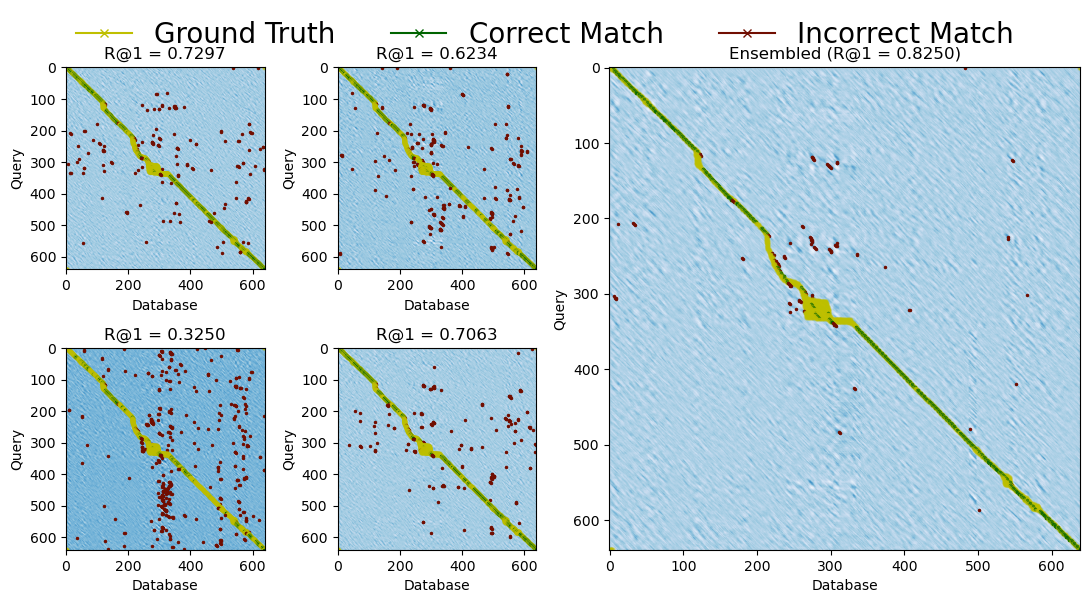

In [22]:
# Methods for visualsing similarity matrices ensembles 
from pathlib import Path
from vpr_methods_evaluation.test_dataset import TestDataset
import numpy as np
from scipy.spatial.distance import cdist
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


def find_crop_start_index(utms, min_dist_m=2.0):
    utms = np.array(utms)
    for i in range(len(utms) - 1):
        dist = np.linalg.norm(utms[i+1] - utms[i])
        if dist >= min_dist_m:
            return i
    return 0  # fallback: no such pair found


def get_rgb_offset(e2vid_r_utms,rgb_r_utms, e2vid_q_utms,rgb_q_utms,):

    # 4. Find index of closest RGB query to the first E2VID query
    qry_start_offset = np.argmin(cdist(e2vid_q_utms, rgb_q_utms[[0]])[:, 0] )
    qry_last_offset = np.argmin(cdist(e2vid_q_utms, rgb_q_utms[[-1]])[:, 0])

    ref_start_offset = np.argmin(cdist(e2vid_r_utms, rgb_r_utms[[0]])[:, 0])
    ref_last_offset = np.argmin(cdist(e2vid_r_utms, rgb_r_utms[[-1]])[:, 0])

    print(f"Query start offset: {qry_start_offset}, last offset: {qry_last_offset}")
    print(f"Reference start offset: {ref_start_offset}, last offset: {ref_last_offset}")

    return qry_start_offset, qry_last_offset, ref_start_offset, ref_last_offset


def seq_match_row_standard(simMat, row_idx, seq_len, seq_match_type='modified'):
    Q, R = simMat.shape

    if seq_match_type == 'seqslam':
        if row_idx < seq_len - 1:
            return np.full(R, -np.inf)
        
        local_mean = uniform_filter1d(simMat, size=min(20, R//4), axis=1, mode='reflect')
        local_std = np.sqrt(uniform_filter1d((simMat - local_mean)**2, size=min(20, R//4), axis=1, mode='reflect')) + 1e-8
        enhanced_sim = (simMat - local_mean) / local_std
        
        seq_scores = np.full(R, -np.inf)
        min_velocity = 0.8
        max_velocity = 1.2
        
        for j in range(seq_len - 1, R):
            best_score = -np.inf
            for v in np.linspace(min_velocity, max_velocity, 10):
                score = 0
                valid_sequence = True
                for k in range(seq_len):
                    q_idx = row_idx - seq_len + 1 + k
                    r_idx = int(j - (seq_len - 1 - k) * v)
                    if r_idx < 0 or r_idx >= R:
                        valid_sequence = False
                        break
                    score += enhanced_sim[q_idx, r_idx]
                if valid_sequence and score > best_score:
                    best_score = score
            seq_scores[j] = best_score
        return seq_scores
    
    elif seq_match_type == 'modified':
        # 1) select the window of rows:
        start_row = max(0, row_idx - seq_len + 1)
        seq = simMat[start_row : row_idx+1 , :]       # shape = (R, num_refs), R ≤ seq_len
        seq = seq.astype(np.float64)
        
        # 2) normalize each column and row of this R×N block
        seq_colnorm = (seq - np.mean(seq, axis=0, keepdims=True)) / (np.std(seq, axis=0, keepdims=True) + 1e-8)
        seq_norm = (seq_colnorm - np.mean(seq_colnorm, axis=1, keepdims=True)) / (np.std(seq_colnorm, axis=1, keepdims=True) + 1e-8)
        
        R, N = seq_norm.shape
        seq_match_row = np.zeros(N, dtype=float)
        # 2) for each column j compute trace of the k×k block ending at j
        for j in range(N):
            k = min(R, j+1)           # grow kernel up to R
            # start column index of block:
            c0 = j - k + 1
            block = seq_norm[-k:, c0:j+1]  # now guaranteed shape (k, k)
            seq_match_row[j] = np.trace(block)

        return seq_match_row
    
    else:
        raise ValueError(f"Unknown sequence matching type: {seq_match_type}")


def apply_sequence_matching(sim_matrix, seq_len, seq_match_type='modified'):
    """
    Applies sequence matching row-wise on the entire similarity matrix.
    Returns a new similarity matrix after applying the seq_match_row logic.
    """
    Q, R = sim_matrix.shape
    matched_sim_matrix = np.zeros_like(sim_matrix)

    # Patch to allow testing both modes without global args
    class Args:
        pass
    args = Args()
    args.seq_match_type = seq_match_type

    for i in range(Q):
        if seq_len == 1:
            matched_sim_matrix[i] = sim_matrix[i]   
        else:   
            matched_sim_matrix[i] = seq_match_row_standard(sim_matrix, i, seq_len, seq_match_type=seq_match_type)

    return matched_sim_matrix


def compute_recall_and_matrix(
    sim_matrix,
    positives_per_query,
    seq_len=1,
    mode='single_simMat',
    seq_match_type='modified',
    apply_sequence_matching_fn=None):
    """
    Parameters:
        sim_matrix: np.ndarray or List[np.ndarray]
            - If mode == 'frame', shape is (num_queries, num_refs)
            - If mode == 'patch', list of 6 matrices (one per patch), each (num_queries, num_refs)
        positives_per_query: List[List[int]]
            - Ground truth positives per query index
        seq_len: int
            - Sequence length for sequence matching
        mode: str
            - 'frame' or 'patch'
        apply_sequence_matching_fn: Callable
            - Function that applies sequence matching

    Returns:
        recall_at_1: float
        final_sim_matrix: np.ndarray of shape (num_queries, num_refs)
    """
    assert mode in ['single_simMat', 'list_simMat'], "mode must be 'frame' or 'patch'"
    assert callable(apply_sequence_matching_fn), "You must provide a valid sequence matching function"

    if mode == 'list_simMat':
        num_queries, num_refs = sim_matrix[0].shape
        combined_matrix = np.zeros((num_queries, num_refs), dtype=np.float32)
        list_simMat=[]
        for j in range(len(sim_matrix)):
            patch_sim = sim_matrix[j]
            patch_seqmatch = apply_sequence_matching_fn(patch_sim, seq_len, seq_match_type)
            list_simMat.append(patch_seqmatch)
            combined_matrix += patch_seqmatch

        final_sim_matrix = combined_matrix  # already summed over patches

    else:  # mode == 'frame'
        final_sim_matrix = apply_sequence_matching_fn(sim_matrix, seq_len, seq_match_type)

    # Compute recall@1
    correct, total = 0, 0
    for i, current_sim in enumerate(final_sim_matrix):
        if len(positives_per_query[i]) == 0:
            continue
        best_match = np.argmax(current_sim)
        correct += int(best_match in positives_per_query[i])
        total += 1

    recall_at_1 = correct / total if total > 0 else 0.0
    return list_simMat, recall_at_1, final_sim_matrix



def plot_ensemble_similarity_matrices(smat_list, fused_smat, positives_per_query, recall):
    """
    Plot 4 ensemble member similarity matrices (small) and the fused matrix (large).
    Layout:
    [M1][M2][      ]
    [M3][M4][FUSED ]
    """
    num_members = len(smat_list)
    if num_members != 4:
        raise ValueError("This plotting layout assumes exactly 4 ensemble members.")

    def compute_recall_at_1(similarity_matrix, positives_per_query):
        correct = 0
        total = len(positives_per_query)
        for q_idx, positives in enumerate(positives_per_query):
            if len(positives) == 0:
                continue
            predicted = np.argmax(similarity_matrix[q_idx])
            if predicted in positives:
                correct += 1
        return correct / total if total > 0 else 0.0

    member_recalls = [compute_recall_at_1(smat, positives_per_query) for smat in smat_list]

    fig = plt.figure(figsize=(11, 6))
    gs = GridSpec(2, 4, figure=fig)

    positions = [(0, 0), (0, 1), (1, 0), (1, 1)]  # grid positions for 4 members

    for i, (row, col) in enumerate(positions):
        ax = fig.add_subplot(gs[row, col])
        mat = smat_list[i]
        im = ax.imshow(mat, aspect='auto', cmap='Blues')
        ax.set_title(f"R@1 = {member_recalls[i]:.4f}")
        ax.set_xlabel("Database")
        ax.set_ylabel("Query")
        ax.grid(False)

        if positives_per_query is not None:
            for q_idx, positives in enumerate(positives_per_query):
                if len(positives) == 0:
                    continue
                ax.plot(positives, [q_idx] * len(positives), 'yo', markersize=2, alpha=0.3)
                member_pred = np.argmax(mat[q_idx])
                correct = member_pred in positives
                color = '#006400' if correct else "#710E01"
                ax.plot(member_pred, q_idx, '.', color=color, markersize=3, alpha=1)

    # Large fused matrix on right spanning rows 0 and 1 in columns 2 and 3
    ax_fused = fig.add_subplot(gs[:, 2:])
    im = ax_fused.imshow(fused_smat, aspect='auto', cmap='Blues')
    ax_fused.set_title(f"Ensembled (R@1 = {recall:.4f})")
    ax_fused.set_xlabel("Database")
    ax_fused.set_ylabel("Query")
    ax_fused.grid(False)

    if positives_per_query is not None:
        for q_idx, positives in enumerate(positives_per_query):
            if len(positives) == 0:
                continue
            ax_fused.plot(positives, [q_idx] * len(positives), 'yo', markersize=2, alpha=0.3)
            predicted = np.argmax(fused_smat[q_idx])
            color = '#006400' if predicted in positives else "#710E01"
            ax_fused.plot(predicted, q_idx, '.', color=color, markersize=3, alpha=1)

    # Custom legend (placed above the plot)
    legend_elements = [
        Line2D([0], [0], marker='x', color='y', label='Ground Truth'),
        Line2D([0], [0], marker='x', color='#006400', label='Correct Match'),
        Line2D([0], [0], marker='x', color='#710E01', label='Incorrect Match'),]
    fig.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.02),
        ncol=3,
        frameon=False, fontsize=20)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space at the top for the legend
    plt.savefig('./plots/0_example_of_ensemble_sim_mats.pdf', bbox_inches='tight', format='pdf')
    plt.show()
    plt.close(fig)


def general_ensemble(
    ref_name: str,
    qry_name: str,
    vpr_methods: list,
    recon_methods: list,
    time_strs: list,
    ensemble_over: str = 'vpr',  # Options: 'vpr', 'recon', 'time', 'patch'
    seqLen: int = 1):
    """
    General ensemble function. Sums similarity matrices across specified dimensions.
    """
    if ref_name.startswith('R0_') or qry_name.startswith('R0_'):
        dataset_name = 'NSAVP'
    else:
        dataset_name = 'Brisbane'

    print(f"Ensembling for {dataset_name} ({ref_name} vs {qry_name}), ensemble_over={ensemble_over}, seqLen={seqLen}")
    suffix = '2_2' if ensemble_over == 'patch' else '1_1'
    mode = 'patch' if ensemble_over == 'patch' else 'frame'
    smat_list = []
    min_rows, min_cols = None, None
    e2vid_q_utm = None  # For E2VID positives
    count = 0  # number of matrices summed

    def subsample_smat(smat, step):
        nonlocal min_rows, min_cols
        rows = np.arange(0, smat.shape[0], step)
        cols = np.arange(0, smat.shape[1], step)
        smat = smat[np.ix_(rows, cols)]
        min_rows = smat.shape[0] if min_rows is None else min(min_rows, smat.shape[0])
        min_cols = smat.shape[1] if min_cols is None else min(min_cols, smat.shape[1])
        return smat

    if ensemble_over == 'patch':
        time_res = float(time_strs[0])
        step = int(1 / time_res)
        base_dir = Path(f"logs/{dataset_name}/fixed_timebins_{time_str}/")
        filename = f"{ref_name}_vs_{qry_name}_{vpr_methods[0]}_l2_reconstruct_{recon_methods[0]}_{time_strs[0]}_{mode}_{suffix}.npy"
        file_path = base_dir / filename
        if not file_path.exists():
            print(f"[!] Missing: {file_path}")
        smat_list = np.load(file_path)
    else:
        # for vpr_method in vpr_methods if 'vpr' in ensemble_over else [vpr_methods[0]]:
        #     for time_str in time_strs if 'time' in ensemble_over else [time_strs[0]]:
        #         for recon_method in recon_methods if 'recon' in ensemble_over else [recon_methods[0]]:
        
        for vpr_method in vpr_methods:
            for time_str in time_strs:
                for recon_method in recon_methods:
                
                    time_res = float(time_str)
                    step = int(1 / time_res)

                    dataset_folder = 'BrisbaneEvent' if dataset_name == 'Brisbane' else 'NSAVP'
                    work_dir = f'../data/{dataset_folder}/image_reconstructions/fixed_timebins_{time_str}'
                    queries_folder = f"{work_dir}/{recon_method}/{qry_name}"
                    database_folder = f"{work_dir}/{recon_method}/{ref_name}"
                    test_ds = TestDataset(
                        database_folder, queries_folder,
                        positive_dist_threshold=25, image_size=None, use_labels=True)
                    r_move=find_crop_start_index(test_ds.database_utms)
                    q_move=find_crop_start_index(test_ds.queries_utms)
                    test_ds.queries_utms = test_ds.queries_utms[q_move:][::step]  # Subsample queries
                    test_ds.database_utms = test_ds.database_utms[r_move:][::step]
                    print(f"len(test_ds.queries_utms)={len(test_ds.queries_utms)}, len(test_ds.database_utms)={len(test_ds.database_utms)}")
                    positives_per_query = test_ds.get_positives()
          
                    if recon_method == 'e2vid' and e2vid_q_utm is None:
                        e2vid_q_utms= test_ds.queries_utms[q_move:]
                        e2vid_r_utms= test_ds.database_utms[r_move:]
                    base_dir = Path(f"logs/{dataset_name}/fixed_timebins_{time_str}/")
                    filename = f"{ref_name}_vs_{qry_name}_{vpr_method}_l2_reconstruct_{recon_method}_{time_str}_{mode}_{suffix}.npy"
                    file_path = base_dir / filename
                    if not file_path.exists():
                        print(f"[!] Missing: {file_path}")
                        continue
                    
                    if recon_method == 'RGB_camera':
                        queries_folder = f"{work_dir}/RGB_camera/{qry_name}"
                        database_folder = f"{work_dir}/RGB_camera/{ref_name}"
                        test_ds = TestDataset(
                            database_folder, queries_folder,
                            positive_dist_threshold=25, image_size=None, use_labels=True)
                        r_move=find_crop_start_index(test_ds.database_utms)
                        q_move=find_crop_start_index(test_ds.queries_utms)
                        rgb_q_utms= test_ds.queries_utms[q_move:]
                        rgb_r_utms= test_ds.database_utms[r_move:]

                        qry_start_offset, qry_last_offset, ref_start_offset, ref_last_offset= get_rgb_offset(e2vid_r_utms, rgb_r_utms,
                            e2vid_q_utms,rgb_q_utms )
                        smat = np.load(file_path)[qry_start_offset:qry_last_offset, ref_start_offset:ref_last_offset]
                        positives_per_query = [p - ref_last_offset for p in positives_per_query[:qry_last_offset]]
                    else:
                        smat = np.load(file_path)[q_move:,r_move:]
                    
                    smat = subsample_smat(smat, step)  
                    smat_list.append(smat)
                    print(f"Loaded other similarity matrix with shape: {smat.shape}")
                    count += 1

    # Check if matrices have different shapes and crop if needed
    if len(smat_list) > 1 and (min_rows is not None and min_cols is not None):
        shapes = [s.shape for s in smat_list]
        smat_list = [s[:min_rows, :min_cols] for s in smat_list] # Crop to smallest shape

    print(f"Shape of combined similarity matrix: {smat_list[0].shape}")
    print(f"Number of queries: {len(positives_per_query)}")
    list_simMat, recall, combinedSimMat = compute_recall_and_matrix(
        smat_list, positives_per_query,
        seq_len=seqLen, mode='list_simMat',
        seq_match_type='modified',
        apply_sequence_matching_fn=apply_sequence_matching)
    print(f"\n\n\n{count} ensembles with recall@1: {recall:.4f} for {dataset_name} ({ref_name} vs {qry_name}), ensemble_over={ensemble_over}, seqLen={seqLen}")
    print(f"Shape of combined similarity matrix: {combinedSimMat.shape}")
    print(f"Number of queries: {len(positives_per_query)}")
    plot_ensemble_similarity_matrices(
    smat_list=list_simMat,
    fused_smat=combinedSimMat,
    positives_per_query=positives_per_query,
    recall=recall)

    return list_simMat, positives_per_query, combinedSimMat, recall

vpr_all = ['mixvpr', 'megaloc', 'cosplace', 'netvlad']
recon_all = ['e2vid', 'eventCount', 'eventCount_noPolarity', 'timeSurface']
time_all = [0.1, 0.25, 0.5, 1.0]
ensemble_groups = ['vpr', 'recon', 'time', 'all']

list_simMat, positives_per_query, combinedSimMat, recall = general_ensemble('sunset1','daytime',
    vpr_methods = ['mixvpr'],
    recon_methods=recon_all,
    time_strs=['1.0'],
    ensemble_over= 'recon',
    seqLen=10)



In [8]:

# build_runtime_tables.py
import sys
import pandas as pd
csv_path ='./results/single_query_grid.csv'  # sys.argv[1]


# ---- FE times from the plot (ms -> s). Adjust if you refine them. ----
FE_MS = {
    "netvlad": 6,
    "cosplace": 4,
    "mixvpr": 4,
    "megaloc": 27.0,
}
FE_S = {k.lower(): v / 1000.0 for k, v in FE_MS.items()}

# ---- Load & augment ----
df = pd.read_csv(csv_path)
df["feature_extractor_norm"] = df["feature_extractor"].str.lower().str.strip()
df["fe_time_s"] = df["feature_extractor_norm"].map(FE_S)
if df["fe_time_s"].isna().any():
    missing = df.loc[df["fe_time_s"].isna(), "feature_extractor"].unique().tolist()
    raise ValueError(f"Missing FE time mapping for: {missing}")

# Per-query runtime for a single combo (one image):
# runtime = reconstruction per-frame + one FE forward
df["per_query_runtime_s"] = df["mean_recon_per_frame_s"] + df["fe_time_s"]

# Helpers
def ms(x): return x * 1000.0
def sum_fe_all_methods() -> float:
    """Sum of FE times across all present methods (one forward each)."""
    methods = df["feature_extractor_norm"].dropna().unique().tolist()
    return float(sum(FE_S[m] for m in methods))

def unique_recon_dt() -> pd.DataFrame:
    """Unique (reconstruction, time_res) pairs in the CSV."""
    return df[["reconstruction", "time_res"]].drop_duplicates().sort_values(["reconstruction","time_res"])

# ============================================================
# 1) Single method (average over all recon × Δt)
# ============================================================
by_method = (
    df.groupby("feature_extractor")["per_query_runtime_s"]
      .mean().sort_values().to_frame("avg_runtime_s")
)
by_method["avg_runtime_ms"] = ms(by_method["avg_runtime_s"])
by_method.to_csv("runtime_single_method.csv")

# ============================================================
# 2) Ensemble of time resolutions
# For a fixed (reconstruction, method): run all Δt.
# Cost = sum over Δt of (recon_per_frame(recon, Δt) + FE_time(method))
# We then average across reconstructions for each method, and also give overall.
# ============================================================
# Precompute table with one row per (reconstruction, time_res) for recon cost
recon_costs = (
    df.drop_duplicates(subset=["reconstruction","time_res"])[
        ["reconstruction","time_res","mean_recon_per_frame_s"]
    ]
)

# Build per (reconstruction, method) ensemble-of-Δt cost
fe_map = df[["feature_extractor","feature_extractor_norm"]].drop_duplicates().set_index("feature_extractor")["feature_extractor_norm"].to_dict()

rows_time_res = []
for recon, g in recon_costs.groupby("reconstruction"):
    for method in sorted(df["feature_extractor"].unique()):
        fe_s = FE_S[fe_map[method]]
        total = float(g["mean_recon_per_frame_s"].sum() + len(g) * fe_s)
        rows_time_res.append({"reconstruction": recon, "feature_extractor": method,
                              "ensemble_time_res_s": total})

ens_time_res_df = pd.DataFrame(rows_time_res)
# Average across reconstructions per method
ens_time_res_by_method = (
    ens_time_res_df.groupby("feature_extractor")["ensemble_time_res_s"]
      .mean().to_frame("avg_ensemble_time_res_s")
)
ens_time_res_by_method["avg_ensemble_time_res_ms"] = ms(ens_time_res_by_method["avg_ensemble_time_res_s"])
ens_time_res_by_method.to_csv("runtime_ensemble_time_res_by_method.csv")

# Overall average across both recon and method (one number)
overall_ensemble_time_res_s = float(ens_time_res_df["ensemble_time_res_s"].mean())

# ============================================================
# 3) Ensemble of feature extractors
# For a fixed (reconstruction, time_res): run ALL methods on the SAME reconstruction.
# Cost per (recon, Δt) = recon_per_frame + sum(FE_times for all methods).
# We report per (recon, Δt), and also averages by recon and by Δt, and overall.
# ============================================================
fe_sum_all = sum_fe_all_methods()
rows_fe = []
for _, row in recon_costs.iterrows():
    r, dt, rc = row["reconstruction"], row["time_res"], row["mean_recon_per_frame_s"]
    total = float(rc + fe_sum_all)
    rows_fe.append({"reconstruction": r, "time_res": dt, "ensemble_feature_extractors_s": total})

ens_fe_df = pd.DataFrame(rows_fe)
ens_fe_df["ensemble_feature_extractors_ms"] = ms(ens_fe_df["ensemble_feature_extractors_s"])
ens_fe_df.sort_values(["reconstruction","time_res"]).to_csv("runtime_ensemble_feature_extractors_per_combo.csv", index=False)

# Averages
ens_fe_by_recon = ens_fe_df.groupby("reconstruction")["ensemble_feature_extractors_s"].mean().to_frame("avg_s")
ens_fe_by_recon["avg_ms"] = ms(ens_fe_by_recon["avg_s"])
ens_fe_by_recon.to_csv("runtime_ensemble_feature_extractors_by_recon.csv")

ens_fe_by_dt = ens_fe_df.groupby("time_res")["ensemble_feature_extractors_s"].mean().to_frame("avg_s")
ens_fe_by_dt["avg_ms"] = ms(ens_fe_by_dt["avg_s"])
ens_fe_by_dt.to_csv("runtime_ensemble_feature_extractors_by_time_res.csv")

overall_ensemble_feature_extractors_s = float(ens_fe_df["ensemble_feature_extractors_s"].mean())

# ============================================================
# 4) Ensemble of reconstructions
# For a fixed (time_res, method): run ALL reconstructions at this Δt.
# Cost = sum over recon of (recon_per_frame(recon, Δt) + FE_time(method))
# We report per (time_res, method) and also averages across Δt and across methods.
# ============================================================
rows_recon = []
# Build recon cost per (recon, dt) pivot for easy summation over recon
pivot_recon_dt = recon_costs.pivot(index="time_res", columns="reconstruction", values="mean_recon_per_frame_s")
for method in sorted(df["feature_extractor"].unique()):
    fe_s = FE_S[fe_map[method]]
    for dt, row in pivot_recon_dt.iterrows():
        rc_sum = float(row.sum())  # sum of recon costs across reconstructions at this Δt
        total = rc_sum + fe_s * len(row.dropna())  # FE once per reconstruction
        rows_recon.append({"feature_extractor": method, "time_res": dt, "ensemble_reconstructions_s": total})

ens_recon_df = pd.DataFrame(rows_recon)
ens_recon_df["ensemble_reconstructions_ms"] = ms(ens_recon_df["ensemble_reconstructions_s"])
ens_recon_df.sort_values(["feature_extractor","time_res"]).to_csv("runtime_ensemble_recons_per_dt_method.csv", index=False)

# Averages
ens_recon_by_method = ens_recon_df.groupby("feature_extractor")["ensemble_reconstructions_s"].mean().to_frame("avg_s")
ens_recon_by_method["avg_ms"] = ms(ens_recon_by_method["avg_s"])
ens_recon_by_method.to_csv("runtime_ensemble_recons_by_method.csv")

ens_recon_by_dt = ens_recon_df.groupby("time_res")["ensemble_reconstructions_s"].mean().to_frame("avg_s")
ens_recon_by_dt["avg_ms"] = ms(ens_recon_by_dt["avg_s"])
ens_recon_by_dt.to_csv("runtime_ensemble_recons_by_time_res.csv")

overall_ensemble_recons_s = float(ens_recon_df["ensemble_reconstructions_s"].mean())


# ============================================================
# 5) Ensemble of ALL combos (complete ensemble)
#
# Sequential pipeline:
#   1) For each (reconstruction, time_res) pair, reconstruct once.
#      There are R reconstructions and T time resolutions:
#          number of (r, dt) pairs = R * T.
#   2) For each of these R*T reconstructed frames, run ALL M feature
#      extractors once.
#
# Total cost:
#   recon_total_s = sum_{(r,dt)} recon(r, dt)
#   fe_total_s    = (R*T) * sum_{m} FE(m)
#   total_s       = recon_total_s + fe_total_s
# ============================================================
recon_total_s = float(recon_costs["mean_recon_per_frame_s"].sum())  # sum over unique (recon, time_res)
num_rt_pairs = len(recon_costs)                                     # R * T (e.g. 16)
methods_present = df["feature_extractor_norm"].dropna().unique().tolist()
fe_sum_all = sum(FE_S[m] for m in methods_present)

fe_total_s = num_rt_pairs * fe_sum_all
complete_ensemble_total_s = recon_total_s + fe_total_s

# ---- Print a compact summary ----
print("\n== Single method (avg over recon × Δt) ==")
# print(by_method.assign(avg_ms=lambda x: ms(x["avg_runtime_s"]))[["avg_runtime_s","avg_runtime_ms"]])
avg_s = by_method["avg_runtime_s"].mean()
avg_ms = ms(avg_s)
avg_row = pd.DataFrame({"avg_runtime_s": [avg_s], "avg_runtime_ms": [avg_ms]}, index=["overall_mean"])
print(pd.concat([by_method, avg_row]))


print("\n== Ensemble of time resolutions ==")
print("(per method; avg across reconstructions)")
print(ens_time_res_by_method[["avg_ensemble_time_res_s","avg_ensemble_time_res_ms"]])
print("Overall mean:", f"{overall_ensemble_time_res_s*1000:.2f} ms")

print("\n== Ensemble of feature extractors ==")
print("Per (reconstruction, Δt): saved to runtime_ensemble_feature_extractors_per_combo.csv")
print("Avg by reconstruction:")
print(ens_fe_by_recon)
print("Avg by time_res:")
print(ens_fe_by_dt)
print("Overall mean:", f"{overall_ensemble_feature_extractors_s*1000:.2f} ms")

print("\n== Ensemble of reconstructions ==")
print("Per (Δt, method): saved to runtime_ensemble_recons_per_dt_method.csv")
print("Avg by method:")
print(ens_recon_by_method)
print("Avg by time_res:")
print(ens_recon_by_dt)
print("Overall mean:", f"{overall_ensemble_recons_s*1000:.2f} ms")

print("\n== Ensemble of ALL 64 combos ==")
print("Unique (recon, Δt) pairs (R×T):", num_rt_pairs)
print("Recon total:", f"{recon_total_s:.3f} s")
print("FE total:", f"{fe_total_s:.3f} s",
      f"(= {num_rt_pairs} pairs × sum(FE)={fe_sum_all:.3f} s)")
print("TOTAL:", f"{complete_ensemble_total_s:.3f} s",
      f"({complete_ensemble_total_s*1000:.1f} ms)")




== Single method (avg over recon × Δt) ==
              avg_runtime_s  avg_runtime_ms
cosplace           0.041383       41.382607
mixvpr             0.041383       41.382607
netvlad            0.043383       43.382607
megaloc            0.064383       64.382607
overall_mean       0.047633       47.632607

== Ensemble of time resolutions ==
(per method; avg across reconstructions)
                   avg_ensemble_time_res_s  avg_ensemble_time_res_ms
feature_extractor                                                   
cosplace                           0.16553                165.530426
megaloc                            0.25753                257.530426
mixvpr                             0.16553                165.530426
netvlad                            0.17353                173.530426
Overall mean: 190.53 ms

== Ensemble of feature extractors ==
Per (reconstruction, Δt): saved to runtime_ensemble_feature_extractors_per_combo.csv
Avg by reconstruction:
                          avg_s 

Similarity matrix shape: (590, 638)
Similarity matrix shape: (590, 638)
Similarity matrix shape: (590, 638)
Similarity matrix shape: (590, 638)


/tmp/ipykernel_2590888/3989161382.py:430: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_sim.show()


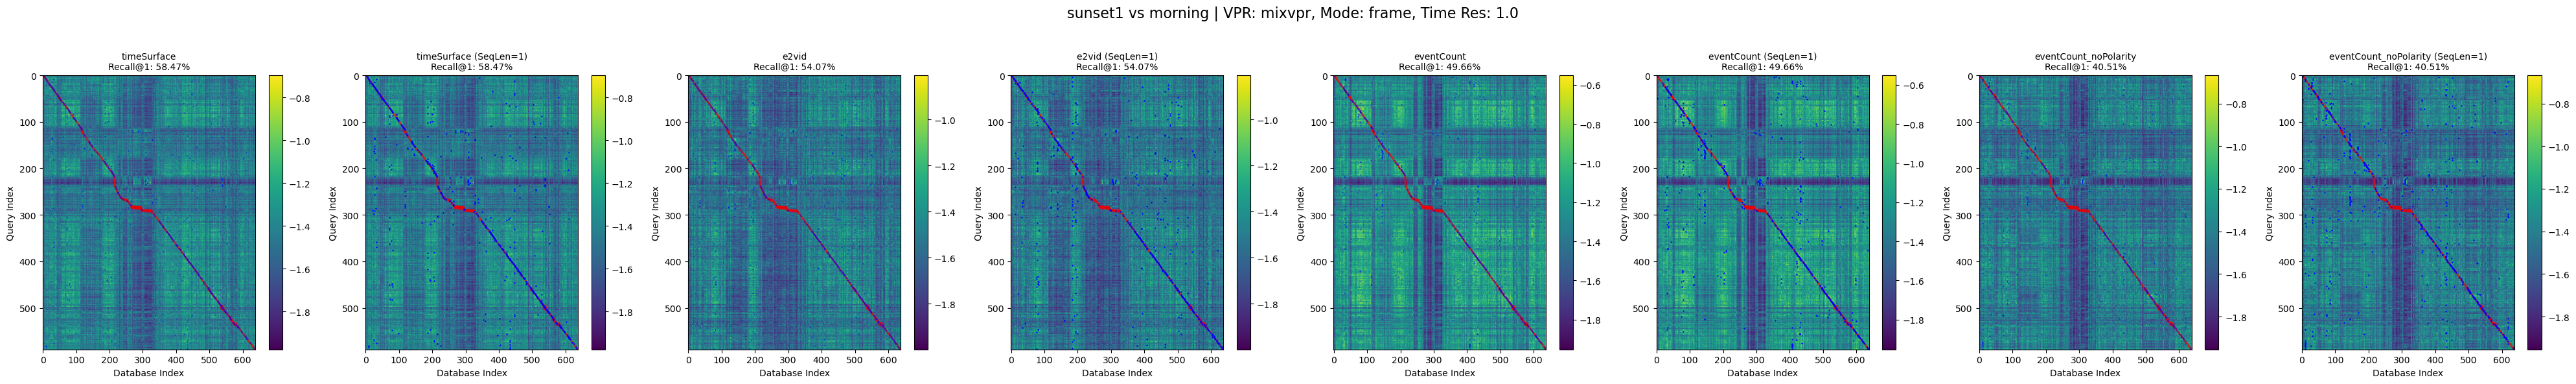

In [13]:
#PR CURVE and sim matrix and sequence matching
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from vpr_methods_evaluation.test_dataset import TestDataset
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy.stats import zscore
import numpy as np
from numba import njit
from scipy.ndimage import uniform_filter1d
from matplotlib import pyplot as plt
from sklearn.metrics import auc
import numpy as np
from tqdm import tqdm
def seq_match_row(simMat, row_idx, seq_len, seq_match_type='modified'):
    """
    Row‑wise diagonal sequence matching using z score normalization to avoid collapse to zero.
    """
    from scipy.ndimage import uniform_filter1d
    Q, R = simMat.shape
    if seq_match_type == 'seqslam':
        if row_idx < seq_len - 1:
            return np.full(R, -np.inf)
        
        local_mean = uniform_filter1d(simMat, size=min(20, R//4), axis=1, mode='reflect')
        local_std = np.sqrt(uniform_filter1d((simMat - local_mean)**2, size=min(20, R//4), axis=1, mode='reflect')) + 1e-8
        enhanced_sim = (simMat - local_mean) / local_std
        
        seq_scores = np.full(R, -np.inf)
        min_velocity = 0.8
        max_velocity = 1.2
        
        for j in range(seq_len - 1, R):
            best_score = -np.inf
            for v in np.linspace(min_velocity, max_velocity, 10):
                score = 0
                valid_sequence = True
                for k in range(seq_len):
                    q_idx = row_idx - seq_len + 1 + k
                    r_idx = int(j - (seq_len - 1 - k) * v)
                    if r_idx < 0 or r_idx >= R:
                        valid_sequence = False
                        break
                    score += enhanced_sim[q_idx, r_idx]
                if valid_sequence and score > best_score:
                    best_score = score
            seq_scores[j] = best_score
        return seq_scores


    elif seq_match_type == 'modified':
        # 1) select the window of rows:
        start_row = max(0, row_idx - seq_len + 1)
        seq = simMat[start_row : row_idx+1 , :]       # shape = (R, num_refs), R ≤ seq_len
        seq = seq.astype(np.float64)
        
        # 2) normalize each column and row of this R×N block
        seq_colnorm = (seq - np.mean(seq, axis=0, keepdims=True)) / (np.std(seq, axis=0, keepdims=True) + 1e-8)
        seq_norm = (seq_colnorm - np.mean(seq_colnorm, axis=1, keepdims=True)) / (np.std(seq_colnorm, axis=1, keepdims=True) + 1e-8)
        
        R, N = seq_norm.shape
        seq_match_row = np.zeros(N, dtype=float)
        # 2) for each column j compute trace of the k×k block ending at j
        for j in range(N):
            k = min(R, j+1)           # grow kernel up to R
            # start column index of block:
            c0 = j - k + 1
            block = seq_norm[-k:, c0:j+1]  # now guaranteed shape (k, k)
            seq_match_row[j] = np.trace(block)

        return seq_match_row

def seq_match_row_standard(simMat, row_idx, seq_len, seq_match_type='seqslam'):
    Q, R = simMat.shape

    if seq_match_type == 'seqslam':
        if row_idx < seq_len - 1:
            return np.full(R, -np.inf)
        
        local_mean = uniform_filter1d(simMat, size=min(20, R//4), axis=1, mode='reflect')
        local_std = np.sqrt(uniform_filter1d((simMat - local_mean)**2, size=min(20, R//4), axis=1, mode='reflect')) + 1e-8
        enhanced_sim = (simMat - local_mean) / local_std
        
        seq_scores = np.full(R, -np.inf)
        min_velocity = 0.8
        max_velocity = 0.8
        
        for j in range(seq_len - 1, R):
            best_score = -np.inf
            for v in np.linspace(min_velocity, max_velocity, 10):
                score = 0
                valid_sequence = True
                for k in range(seq_len):
                    q_idx = row_idx - seq_len + 1 + k
                    r_idx = int(j - (seq_len - 1 - k) * v)
                    if r_idx < 0 or r_idx >= R:
                        valid_sequence = False
                        break
                    score += enhanced_sim[q_idx, r_idx]
                if valid_sequence and score > best_score:
                    best_score = score
            seq_scores[j] = best_score
        return seq_scores
    
    elif seq_match_type == 'modified':
        # 1) select the window of rows:
        start_row = max(0, row_idx - seq_len + 1)
        seq = simMat[start_row : row_idx+1 , :]       # shape = (R, num_refs), R ≤ seq_len
        seq = seq.astype(np.float64)
        
        # 2) normalize each column and row of this R×N block
        seq_colnorm = (seq - np.mean(seq, axis=0, keepdims=True)) / (np.std(seq, axis=0, keepdims=True) + 1e-8)
        seq_norm = (seq_colnorm - np.mean(seq_colnorm, axis=1, keepdims=True)) / (np.std(seq_colnorm, axis=1, keepdims=True) + 1e-8)
        
        R, N = seq_norm.shape
        seq_match_row = np.zeros(N, dtype=float)
        # 2) for each column j compute trace of the k×k block ending at j
        for j in range(N):
            k = min(R, j+1)           # grow kernel up to R
            # start column index of block:
            c0 = j - k + 1
            block = seq_norm[-k:, c0:j+1]  # now guaranteed shape (k, k)
            seq_match_row[j] = np.trace(block)

        return seq_match_row
    
    else:
        raise ValueError(f"Unknown sequence matching type: {seq_match_type}")

def apply_sequence_matching(sim_matrix, seq_len, seq_match_type='modified'):
    """
    Returns a new similarity matrix after applying the seq_match_row logic.
    """
    Q, R = sim_matrix.shape
    matched_sim_matrix = np.zeros_like(sim_matrix)

    # Patch to allow testing both modes without global args
    class Args:
        pass
    args = Args()
    args.seq_match_type = seq_match_type

    for i in range(Q):
        if seq_len == 1:
            matched_sim_matrix[i] = sim_matrix[i]   
        else:   
            matched_sim_matrix[i] = seq_match_row_standard(sim_matrix, i, seq_len, seq_match_type=seq_match_type)

    return matched_sim_matrix

def compute_recall_and_matrix(
    sim_matrix,
    positives_per_query,
    seq_len=1,
    mode='frame',
    seq_match_type='modified',
    apply_sequence_matching_fn=None
):
    """
    Parameters:
        sim_matrix: np.ndarray or List[np.ndarray]
            - If mode == 'frame', shape is (num_queries, num_refs)
            - If mode == 'patch', list of 6 matrices (one per patch), each (num_queries, num_refs)
        positives_per_query: List[List[int]]
            - Ground truth positives per query index
        seq_len: int
            - Sequence length for sequence matching
        mode: str
            - 'frame' or 'patch'
        apply_sequence_matching_fn: Callable
            - Function that applies sequence matching

    Returns:
        recall_at_1: float
        final_sim_matrix: np.ndarray of shape (num_queries, num_refs)
    """
    assert mode in ['frame', 'patch'], "mode must be 'frame' or 'patch'"
    assert callable(apply_sequence_matching_fn), "You must provide a valid sequence matching function"

    if mode == 'patch':
        num_queries, num_refs = sim_matrix[0].shape
        combined_matrix = np.zeros((num_queries, num_refs), dtype=np.float32)

        for j in range(len(sim_matrix)):
            patch_sim = sim_matrix[j]
            patch_seqmatch = apply_sequence_matching_fn(patch_sim, seq_len, seq_match_type)
            combined_matrix += patch_seqmatch

        final_sim_matrix = combined_matrix  # already summed over patches

    else:  # mode == 'frame'
        final_sim_matrix = apply_sequence_matching_fn(sim_matrix, seq_len, seq_match_type)

    # Compute recall@1
    correct, total = 0, 0
    for i, current_sim in enumerate(final_sim_matrix):
        if len(positives_per_query[i]) == 0:
            continue
        best_match = np.argmax(current_sim)
        correct += int(best_match in positives_per_query[i])
        total += 1

    recall_at_1 = correct / total if total > 0 else 0.0
    return recall_at_1, final_sim_matrix

def getPRCurve_sim(similarity_matrix, positives_per_query):
    """
    Calculate PR curve and recall@1 given a similarity matrix.

    Args:
        similarity_matrix: (N_queries, N_database) similarity scores
        positives_per_query: list of lists, where positives_per_query[i] contains 
                             the database indices that are positive matches for query i

    Returns:
        precisions: list of precision values (in [0, 1])
        recalls: list of recall values (in [0, 1])
        auc: area under the precision-recall curve
        recall_at_1: recall@1 (in [0, 1])
    """
    mInds = np.argmax(similarity_matrix, axis=1)  # Best match index per query
    mSims = np.max(similarity_matrix, axis=1)     # Best match similarity per query

    n_queries = similarity_matrix.shape[0]
    assert len(positives_per_query) == n_queries

    mInds = mInds.reshape(-1)
    mSims = mSims.reshape(-1)

    # --- Recall@1 ---
    correct_at_1 = sum(
        mInds[i] in positives_per_query[i] for i in range(n_queries) if len(positives_per_query[i]) > 0
    )
    valid_queries = sum(len(p) > 0 for p in positives_per_query)
    recall_at_1 = correct_at_1 / valid_queries if valid_queries > 0 else 0.0

    # --- PR Curve ---
    prfData = []
    ub, lb = np.max(mSims), np.min(mSims)
    step = (ub - lb) / 100.0
    thresholds = np.arange(lb, ub + step, step)

    for thresh in thresholds:
        matchFlags = mSims >= thresh
        outVals = mInds.copy()
        outVals[~matchFlags] = -1

        correct = total = relevant = 0
        for i in range(n_queries):
            if len(positives_per_query[i]) == 0:
                continue
            relevant += 1
            pred = int(outVals[i])
            if pred != -1:
                total += 1
                if pred in positives_per_query[i]:
                    correct += 1

        p = correct / total if total > 0 else 0.0
        r = correct / relevant if relevant > 0 else 0.0
        prfData.append([p, r])

    if len(prfData) > 1:
        precisions, recalls = zip(*sorted(prfData, key=lambda x: x[1]))
        auc = np.trapz(precisions, recalls)
    else:
        precisions, recalls, auc = [], [], 0.0

    return list(precisions), list(recalls), auc, recall_at_1

def plot_all_pr_curves_grid(ref_qry_pairs, recon_methods, bin_name, vpr_method, time_str, mode, seqLen=1, seq_match_type='modified'):
    """
    Wrapper to extract PR curve data and plot all 10 ref-query pairs in a 2x5 grid.
    
    Parameters:
        ref_qry_pairs: list of (dataset_name, ref_name, qry_name)
        recon_methods: list of reconstruction method names
        bin_name: str, name of binning method
        vpr_method: str, VPR method name
        time_str: str, time resolution as string (e.g., '1.0')
        mode: str, 'frame' or 'patch'
        seqLen: int, sequence length
        seq_match_type: str, sequence matching algorithm name
    """
    
    colors = plt.cm.tab10(range(len(recon_methods)))
    fig, axes = plt.subplots(2, 5, figsize=(25, 10))
    for idx, (dataset_name, ref_name, qry_name) in enumerate(ref_qry_pairs):
        print(f"\n--- Processing {ref_name} vs {qry_name} ---")
        
        row, col = divmod(idx, 5)
        ax = axes[row, col]

        all_seq_matrices, all_gt_positives = similarity_matrices_multi(
            dataset_name=dataset_name,
            bin_name=bin_name,
            ref_name=ref_name,
            qry_name=qry_name,
            recon_methods=recon_methods,
            vpr_method=vpr_method,
            time_str=time_str,
            mode=mode,
            seq_match_type=seq_match_type,
            seqLen=seqLen,
            plot_similarity_matrices=False
        )

        for i, (sim_matrix, gt_positives, method) in enumerate(zip(all_seq_matrices, all_gt_positives, recon_methods)):
            precisions, recalls, auprc, recall_at_1 = getPRCurve_sim(
                sim_matrix, gt_positives
            )

            if len(precisions) > 0:
                # Plot PR curve
                ax.plot(recalls, precisions, label=f"{method} (Recall@1 = {recall_at_1:.2f}) (AUC={auprc:.2f})", color=colors[i])
                ax.scatter(recall_at_1, precisions[-1], marker='x', s=80, color=colors[i])
                ax.legend(loc='lower right', fontsize=8)

        ax.set_title(f"{ref_name} vs {qry_name}", fontsize=12)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True)
            

    plt.suptitle("PR Curves Across Ref-Query Pairs", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def similarity_matrices_multi(dataset_name, bin_name, ref_name, qry_name, recon_methods, vpr_method, time_str, mode, seqLen=1, seq_match_type='modified', plot_similarity_matrices=False):
    import matplotlib.pyplot as plt
    from pathlib import Path

    def compute_motion(utms):
        deltas = np.linalg.norm(np.diff(utms, axis=0), axis=1)
        deltas = np.insert(deltas, 0, 0.0)  # pad to match length
        return deltas
    num_methods = len(recon_methods)
    if plot_similarity_matrices == True:
        fig_sim, axes_sim = plt.subplots(1, 2 * num_methods, figsize=(10 * num_methods, 6))

        if num_methods == 1:
            axes_sim = [axes_sim[0], axes_sim[1]]  # ensure 2-element list if only one method
    all_seq_matrices, all_gt_positives = [], []
    for i, recon_method in enumerate(recon_methods):
        base_dir = Path(f"logs/{dataset_name}/{bin_name}_{time_str}/")
        dataset_folder = 'BrisbaneEvent' if dataset_name == 'Brisbane' else 'NSAVP'

        work_dir = f'../data/{dataset_folder}/image_reconstructions/{bin_name}_{time_str}/{recon_method}'
        queries_folder = f"{work_dir}/{qry_name}"
        database_folder = f"{work_dir}/{ref_name}"
        test_ds = TestDataset(database_folder, queries_folder, positive_dist_threshold=25, image_size=None, use_labels=True)
        
        # find start of motion in query and database
        qry_utms = test_ds.queries_utms
        db_utms = test_ds.database_utms
        motion_thresh = 2.0  # in meters
        qry_motion = compute_motion(qry_utms)
        db_motion = compute_motion(db_utms)
        qry_start = np.argmax(qry_motion > motion_thresh)
        db_start = np.argmax(db_motion > motion_thresh)

        # Load similarity matrix
        time_str_simmat = time_str if bin_name.startswith('fixed') else 'None'
        filename = f"{ref_name}_vs_{qry_name}_{vpr_method}_l2_reconstruct_{recon_method}_{time_str_simmat}_{mode}_1_1.npy"
        file_path = base_dir / filename
        sim_matrix = np.load(file_path)
        sim_matrix = sim_matrix[qry_start:, db_start:]

        #get positives per query
        positives_per_query = test_ds.get_positives()
        positives_per_query = [p - db_start for p in positives_per_query[qry_start:]]
        positives_per_query = [p[p >= 0] for p in positives_per_query]  # remove negatives
        

        # Compute recall@1
        recall_at_1, seq_matrix = compute_recall_and_matrix(
            sim_matrix, positives_per_query, seq_len=seqLen,
            mode=mode, seq_match_type=seq_match_type, apply_sequence_matching_fn=apply_sequence_matching)
        
        # Convert positives to binary matrix
        assert len(positives_per_query) == sim_matrix.shape[0], "Mismatch in number of queries and positives"
        # seq_matrix += abs(np.min(sim_matrix)) # ensure no negative values
        all_gt_positives.append(positives_per_query)
        all_seq_matrices.append(seq_matrix)

        if plot_similarity_matrices == True:
            recall_at_1_no_seqMat, sim_matrix_sum = compute_recall_and_matrix(
                sim_matrix, positives_per_query, seq_len=1,
                mode=mode, seq_match_type=seq_match_type, apply_sequence_matching_fn=apply_sequence_matching)

            # Plot: similarity matrix
            ax1 = axes_sim[2 * i]
            im1 = ax1.imshow(sim_matrix_sum, cmap='viridis', interpolation='nearest', aspect='auto')

            # Plot positives in red
            for q_idx, positives in enumerate(positives_per_query):
                if len(positives) > 0:
                    ax1.scatter(positives, [q_idx] * len(positives), c='red', s=0.1, alpha=0.4, label='Positives' if q_idx == 0 else "")
            predicted = sim_matrix_sum.argmax(axis=1)
            ax1.scatter(predicted, np.arange(len(predicted)), c='blue', s=0.1, label='Predicted (Argmax)')
            ax1.set_title(f"{recon_method}\nRecall@1: {recall_at_1_no_seqMat:.2%}", fontsize=10)
            ax1.set_xlabel("Database Index")
            ax1.set_ylabel("Query Index")
            fig_sim.colorbar(im1, ax=ax1)

            print("Similarity matrix shape:", sim_matrix_sum.shape)

            # Plot: sequence matrix
            ax2 = axes_sim[2 * i + 1]
            im2 = ax2.imshow(seq_matrix, cmap='viridis', interpolation='nearest', aspect='auto')
            # RED: Ground truth positives
            for q_idx, positives in enumerate(positives_per_query):
                if len(positives) > 0:
                    ax2.scatter(positives, [q_idx] * len(positives), c='red', s=0.1, alpha=0.4, label='Positives' if q_idx == 0 else "")
            # BLUE: Predicted matches (argmax across each row)
            predicted = seq_matrix.argmax(axis=1)  # shape: (num_queries,)
            ax2.scatter(predicted, np.arange(len(predicted)), c='blue', s=0.5, label='Predicted')


            ax2.set_title(f"{recon_method} (SeqLen={seqLen})\nRecall@1: {recall_at_1:.2%}", fontsize=10)
            ax2.set_xlabel("Database Index")
            ax2.set_ylabel("Query Index")
            fig_sim.colorbar(im2, ax=ax2)

    # Suptitle
    if plot_similarity_matrices == True:
        fig_sim.suptitle(f"{ref_name} vs {qry_name} | VPR: {vpr_method}, Mode: {mode}, Time Res: {time_str}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        fig_sim.show()


    return all_seq_matrices, all_gt_positives

    # plot_recall_at_k(all_seq_matrices, positives_per_query, recon_methods, k_values=[1, 5, 10, 20, 50, 100])

mode='frame'
alg= 'modified'  # 'seqslam' or 'modified'
recon_methods = ['timeSurface',  'e2vid', 'eventCount', 'eventCount_noPolarity']
vpr_feature_extractors = ['mixvpr', 'megaloc', 'cosplace', 'netvlad']
time_window_resolutions = [0.1, 0.25, 0.5, 1.0]
ref_qry_pairs = [
    ('Brisbane', 'sunset1', 'night'),
    ('Brisbane', 'sunset1', 'morning'),
    ('Brisbane', 'sunset1', 'sunrise'),
    ('Brisbane', 'sunset1', 'sunset2'),
    ('Brisbane', 'sunset1', 'daytime'),
    ('NSAVP', 'R0_FA0', 'R0_FS0'),
    ('NSAVP', 'R0_FA0', 'R0_FN0'),
    ('NSAVP', 'R0_FN0', 'R0_FS0'),
    ('NSAVP', 'R0_RS0', 'R0_RN0'),
    ('NSAVP', 'R0_RA0', 'R0_RN0'),]

all_seq_matrices, all_gt_positives=similarity_matrices_multi(
    dataset_name='Brisbane',
    bin_name='fixed_timebins',
    ref_name='sunset1',
    qry_name='morning',
    recon_methods=recon_methods,
    vpr_method='mixvpr',
    time_str='1.0',
    mode=mode,
    seqLen=1,
    seq_match_type='modified',
    plot_similarity_matrices=True
)

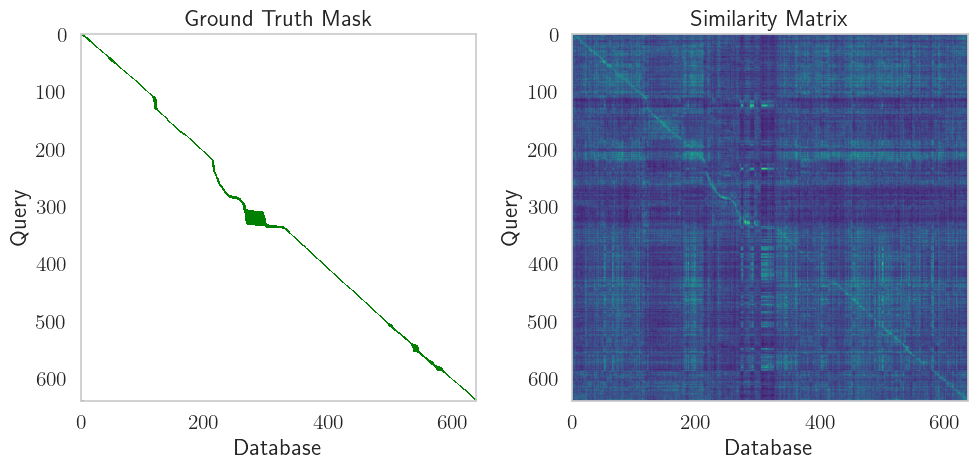

In [ ]:

from pathlib import Path
from vpr_methods_evaluation.test_dataset import TestDataset
import numpy as np
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap

# --- Load similarity matrix ---
ref_name = 'sunset1'
qry_name = 'daytime'
vpr_method = 'megaloc'
recon_method = 'e2vid'
time_str = '1.0'
mode = 'frame'
dataset_name = 'NSAVP' if ref_name.startswith('R0_') or qry_name.startswith('R0_') else 'Brisbane'
base_dir = Path(f"logs/{dataset_name}/fixed_timebins_{time_str}/")
filename = f"{ref_name}_vs_{qry_name}_{vpr_method}_l2_reconstruct_{recon_method}_{time_str}_{mode}_1_1.npy"
file_path = base_dir / filename
sim_matrix = np.load(file_path)

# --- Load ground truth positives ---
dataset_folder = 'BrisbaneEvent' if dataset_name == 'Brisbane' else 'NSAVP'
work_dir = f'../data/{dataset_folder}/image_reconstructions/fixed_timebins_{time_str}'
queries_folder = f"{work_dir}/{recon_method}/{qry_name}"
database_folder = f"{work_dir}/{recon_method}/{ref_name}"

# Load your TestDataset class and get positives
test_ds = TestDataset(
    database_folder, queries_folder,
    positive_dist_threshold=25, image_size=None, use_labels=True)
positives_per_query = test_ds.get_positives()

# --- Create ground truth mask ---
Nq, Nd = sim_matrix.shape
gt_mask = np.zeros((Nq, Nd), dtype=bool)
for q_idx, positives in enumerate(positives_per_query):
    gt_mask[q_idx, positives] = True

# --- Create correct/incorrect match matrix ---
correct_matches = np.zeros_like(gt_mask, dtype=bool)
incorrect_matches = np.zeros_like(gt_mask, dtype=bool)

for q_idx in range(Nq):
    predicted = np.argmax(sim_matrix[q_idx])
    if predicted in positives_per_query[q_idx]:
        correct_matches[q_idx, predicted] = True
    else:
        incorrect_matches[q_idx, predicted] = True

# --- Plotting 3 subplots ---
fig = plt.figure(figsize=(15, 5))
gs = GridSpec(1, 3, figure=fig)


# 1. Similarity Matrix
ax1 = fig.add_subplot(gs[1])
im1 = ax1.imshow(sim_matrix, aspect='auto', cmap='viridis')
ax1.set_title("Similarity Matrix")
ax1.set_xlabel("Database")
ax1.set_ylabel("Query")


# 2. Ground Truth Mask
# Create a custom colormap for the ground truth mask: 0 -> white, 1 -> green
custom_cmap = ListedColormap(['white', 'green'])
ax2 = fig.add_subplot(gs[0])
im2 = ax2.imshow(gt_mask, aspect='auto', cmap=custom_cmap, vmin=0, vmax=1)
ax2.set_title("Ground Truth Mask")
ax2.set_xlabel("Database")
ax2.set_ylabel("Query")

ax1.grid(False)
ax2.grid(False)





plt.tight_layout()
plt.savefig('/Users/theresejoseph/Downloads/ThesisFigs/similarity_matrix_example.pdf', bbox_inches='tight')
plt.show()
